# Aim
Choosing countries for NGO funding, which are in the direst need of aid, based on socio-economic and health factors 
that determine the overall development of the country. 


### Solution:
We will use unsupervised machine learning - "clustering" for segmenting the countries into aided and non-aided, in the above problem statement. 

### Steps: 
- Preprocessing:
    - Collect and clean data from any garbage values and duplicate records
    - Perform outlier analysis and cap the values in 5-95% quartile during processing, and restore to original values during final analysis
    - Visualize data to identify patterns or correlations
    - Scale up/down the continuous features to the same range, for correct working of ML algorithms
    - Check if data has tendency to form clusters
- Cluster Analysis:
    - Perform K-means analysis and Hierarchical (complete-linkage and single-linkage) analysis
    - Identify optimum number of clusters
- Cluster Profiling 
    - cluster data visualization
    - Scores
    - Story building around each of the clusters 


In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# visualization
from matplotlib.pyplot import xticks
%matplotlib inline

from IPython.display import display

# To perform Hierarchical clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

# Read, inspect and clean data

### 1.  Load dataset from file

In [2]:

# Data display 
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

In [3]:
data = pd.read_csv('Country-data.csv')

### 2. Inspect dataset

In [4]:
data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [5]:
data.shape

(167, 10)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [7]:
data.describe()


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


##### Conclusion:
- Dataframe has 10 Columns and 167 Rows 
- Dataframe has data about various countries and their socio-economic factors. 
- One variable is 'Object' Type, and rest all are 'Int' or 'Float' type  
- There is lot of variation between the min and mean/25% values of each column. As k-means algorithm computes the Euclidean distance between the data points, it is important to ensure that the attributes with a larger range of values do not out-weight the attributes with smaller range. Hence we will have to <b>scale/normalize</b> the columns.
- Also there is lot of variation between max and mean/75%. This means we <b>expect outliers</b> to be present in these numerical cols. 

### 3. Cleaning data

In [8]:
#Take backup before cleaning values 
data_backup1 = data.copy()

#### 3.1 Checking duplicates


In [9]:
sum(data.duplicated(subset = 'country')) == 0

True

###### Conclusion : 
- The  presence  of  duplicate  records  is  a  major  concern  for data quality in large databases. 
- However we have confirmed that our dataset has <b>no duplicate</b> values

#### 3.2 Missing(null) values

In [10]:
data.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

##### Conclusion:
- Clustering algorithms group the data points based on some similarity criteria. 
- If there are missing values in data, then naturally the clustering algorithm will give incorrect results. 
- Hence we have ensured that there are <b>no missing</b> values.

#### 3.3 Handling Outliers

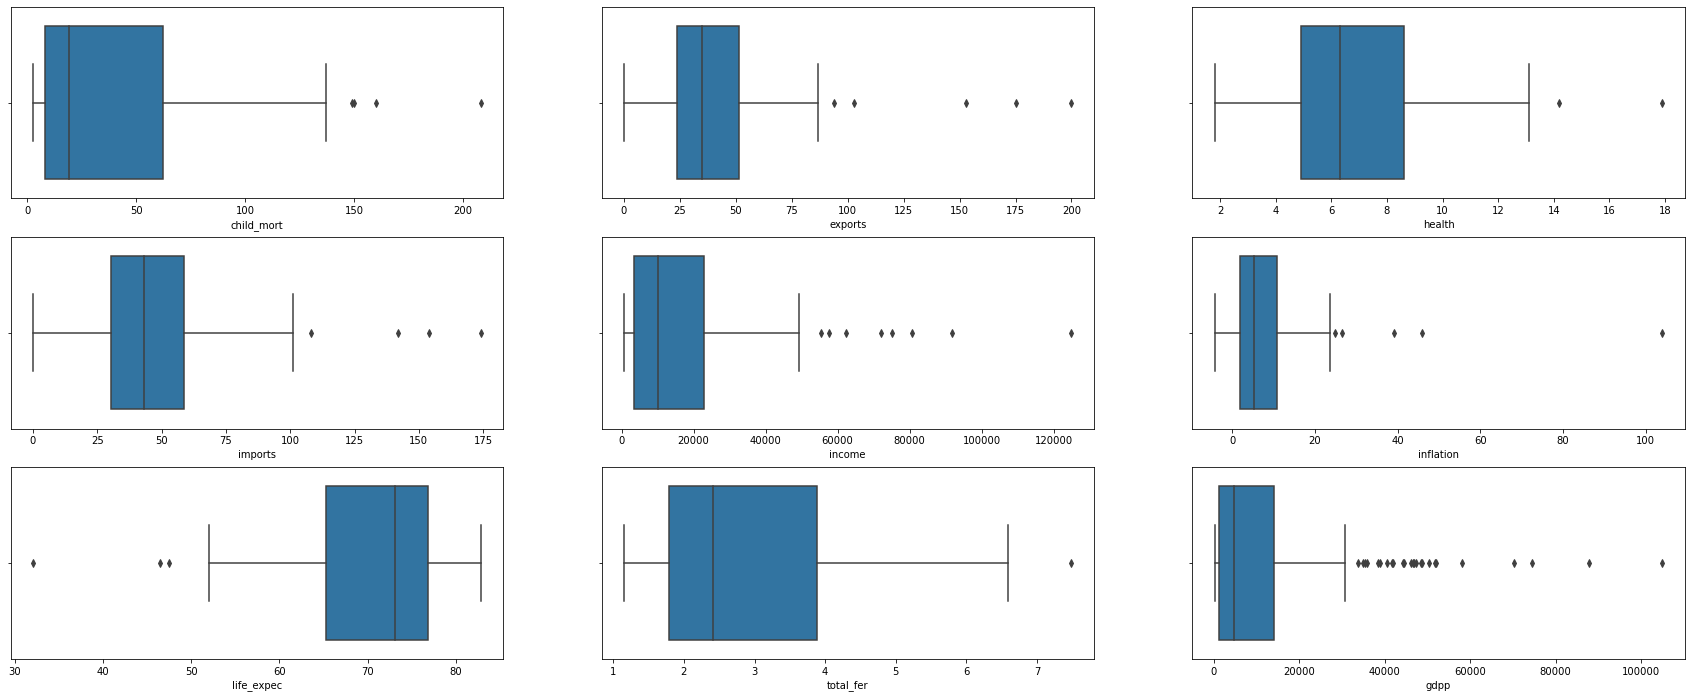

In [11]:
# Plot boxplot before capping
num_cols = data.select_dtypes(include=['int64','float64']).columns.tolist()

plt.figure(figsize=(30, 12))

i=1
for c in num_cols:
    plt.subplot(3,3,i)
    sns.boxplot(data[c])
    i = i + 1
plt.show()



In [12]:
# Capping outliers between Q1 and Q3
# data.describe()

for c in num_cols:
    Q1=0.05
    Q3=0.95
    percentiles = data[c].quantile([Q1,Q3]).values
#     display(c,"====\n",percentiles)
    data[c][data[c] <= percentiles[0]] = percentiles[0]
    data[c][data[c] >= percentiles[1]] = percentiles[1]
    
# data.describe()



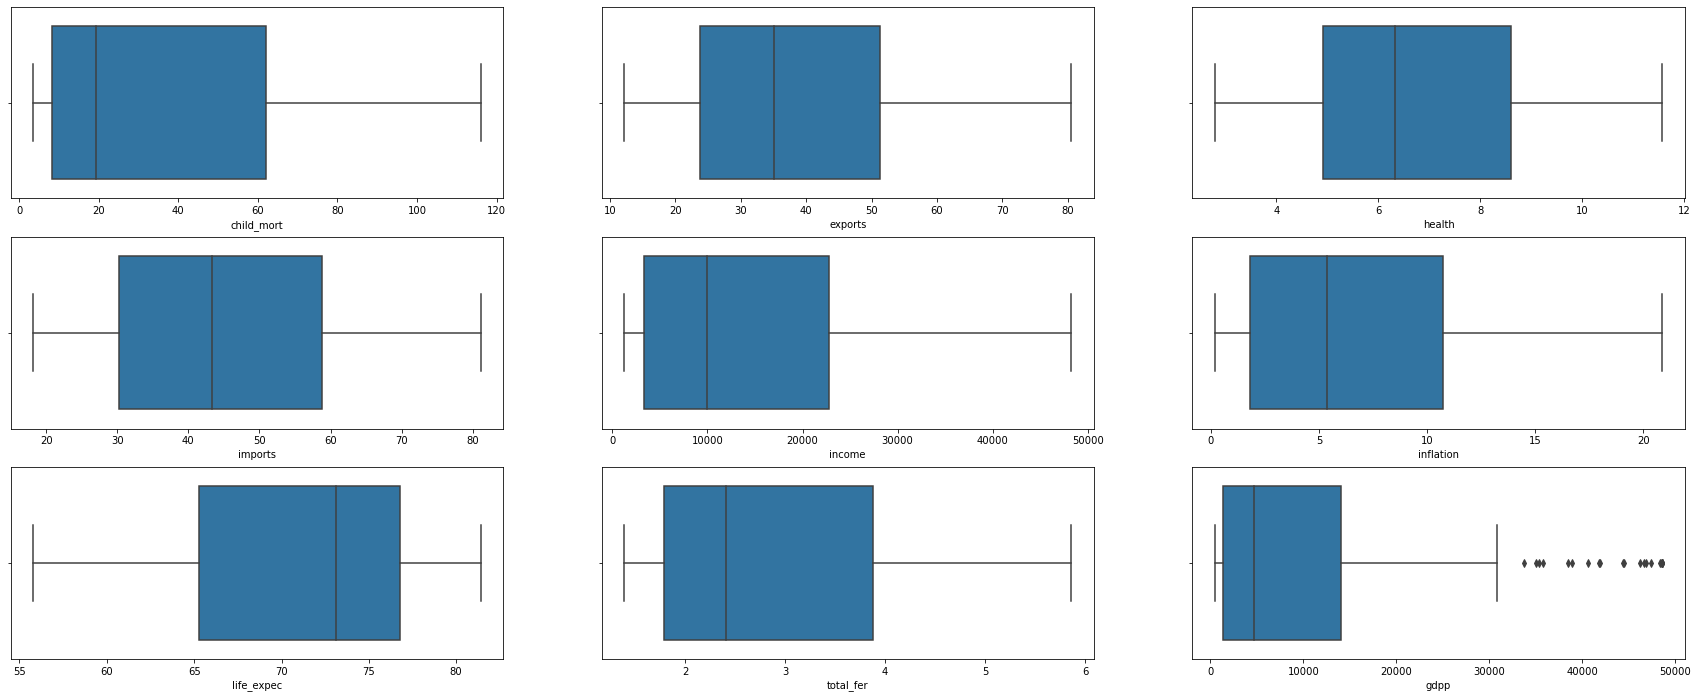

In [13]:
# Plot boxplot after capping to 5%-95%
num_cols = data.select_dtypes(include=['int64','float64']).columns.tolist()

plt.figure(figsize=(30, 12))

i=1
for c in num_cols:
    plt.subplot(3,3,i)
    sns.boxplot(data[c])
    i = i + 1
plt.show()

### Conclusion

- There are a number of outliers in the data.
- Since our k-means and agglomerative techniques are affected by outliers, we need to remove or cap the outliers. If we had used only DBSCAN method, then it is not affected by outliers and we could have skipped this step. If we do not apply Outlier treatment, it can impact the clustering model, as the presence of Outlier can change the CENTROID (K-Means) of the cluster. 
- In this case study, we cannot remove the outlier records because we will lose complete information of that country.
- We have capped the outliers to fit in 5-95% of most of the values accordingly for analysis.
- As we have applied outlier treatment by <b>capping this will change the ranking</b> of few countries with respect to requirement of Financial Aid. We will consider this factor <b>during final analysis</b>.
- Also we will <b>still have some outliers</b> present after Capping. 

# Exploratory Data Analysis 

### 1. Separate Categorical and Numerical variables

In [14]:
num_cols = data.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = data.select_dtypes(exclude=['int64','float64']).columns.tolist()
display("\n=============Numerical cols==== :\n ",num_cols)
display("\n=============Categorical cols===== : \n",cat_cols)

'\n=============Numerical cols==== :\n '

['child_mort',
 'exports',
 'health',
 'imports',
 'income',
 'inflation',
 'life_expec',
 'total_fer',
 'gdpp']

'\n=============Categorical cols===== : \n'

['country']

##### Conclusion:
We have separated the only categorical column which is "country" and the remaining 9 numerical columns 

### 2. Univariate Analysis of Numerical cols  

In [15]:
data.shape

(167, 10)

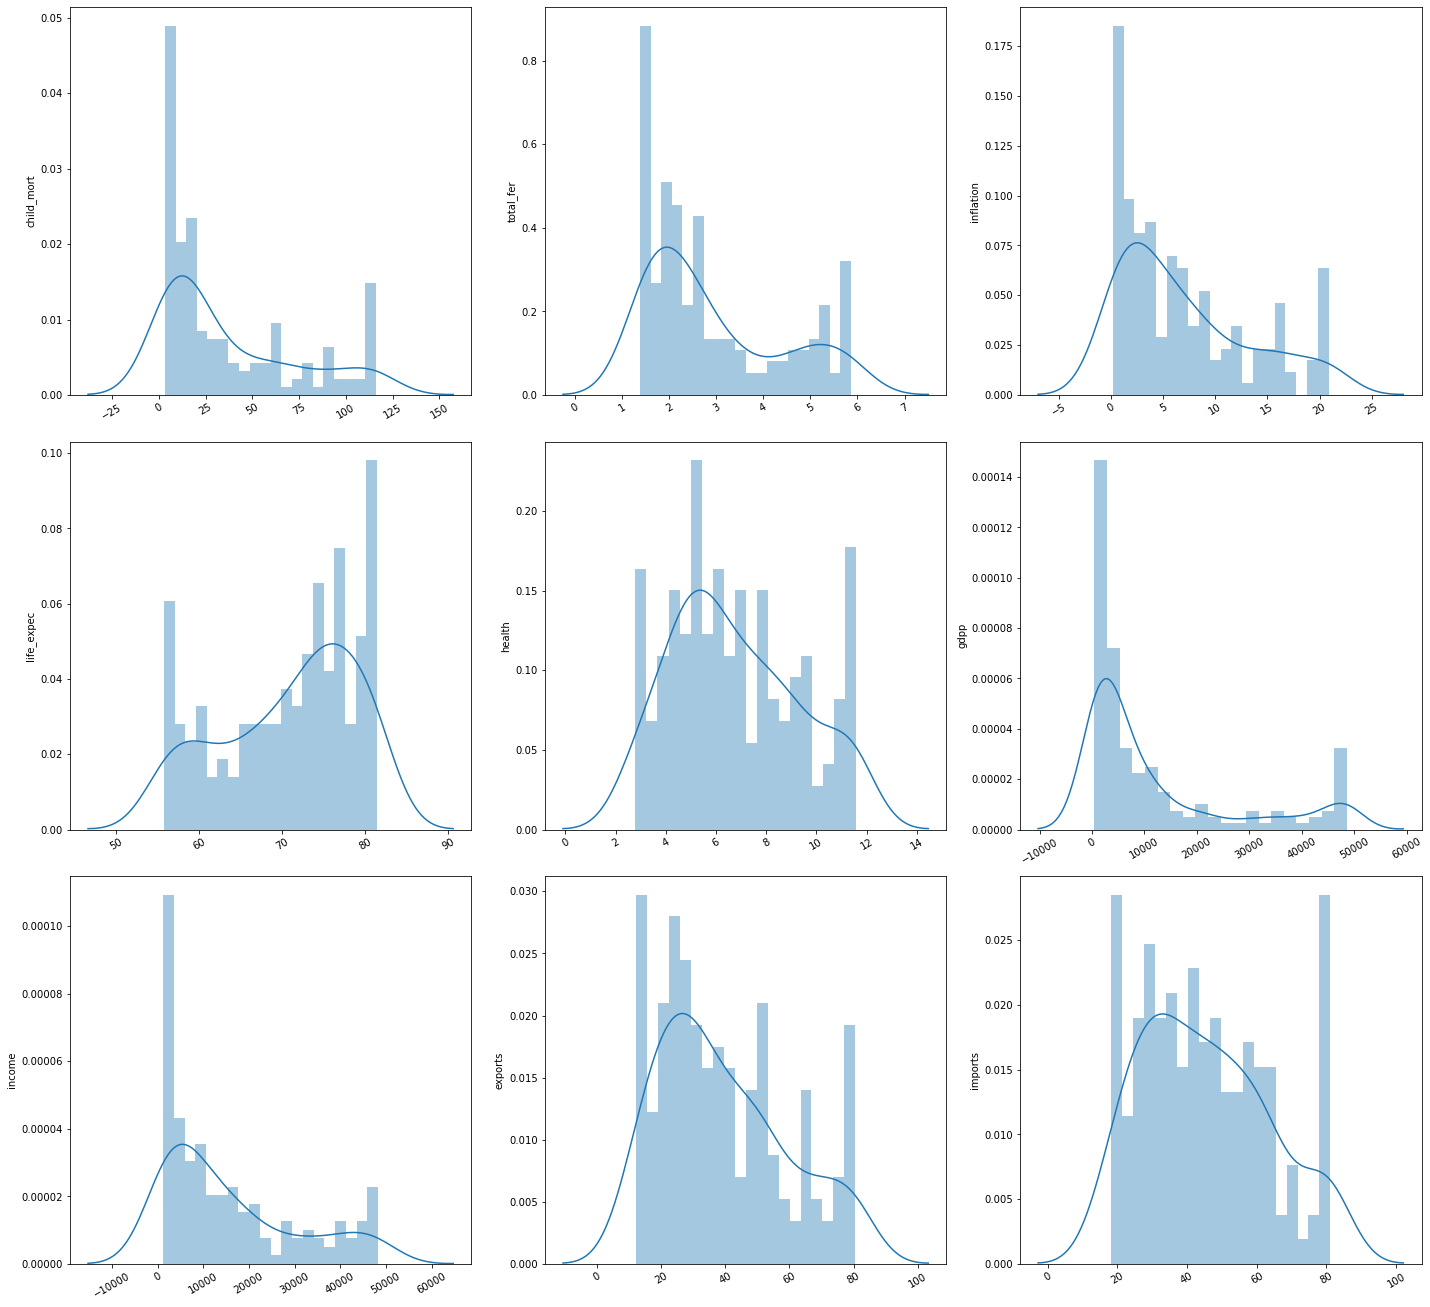

In [16]:

# Find the countries with highest: Child Mortality Rate,Fertility Rate, Inflation
# Find the countries with lowest: Life Expectancy, Health, GDP,Income,Imports,Exports
cols=['child_mort','total_fer','inflation','life_expec','health','gdpp','income','exports','imports']

# Bin the data and plot the dist plot of the numerical terms
plt.figure(figsize=(20, 60))
i=1
sortAsc=False
for c in cols:
    ax2 = plt.subplot(10,3,i)
    if(i>3):
        sortAsc = True
    top10_df = data[['country',c]].sort_values(c, ascending = sortAsc).head(20)
#     sns.barplot(x='country', y=c, data= top10_df, ax = ax2)
    sns.distplot(data[c], bins = 20,ax=ax2)
    ax2.set(xlabel=None, ylabel=c)
    plt.xticks(rotation=30)
    i = i + 1

plt.tight_layout()
plt.show()

### Conclusion : 
- Most of the data point are <b>not normally</b> distributed. 
- They have <b>different variance</b>. 
- They have <b>different range</b> which indicates that we will have to standardize/normalize the columns. 

### 4. Bivariate Analysis - Numerical Vs Numerical

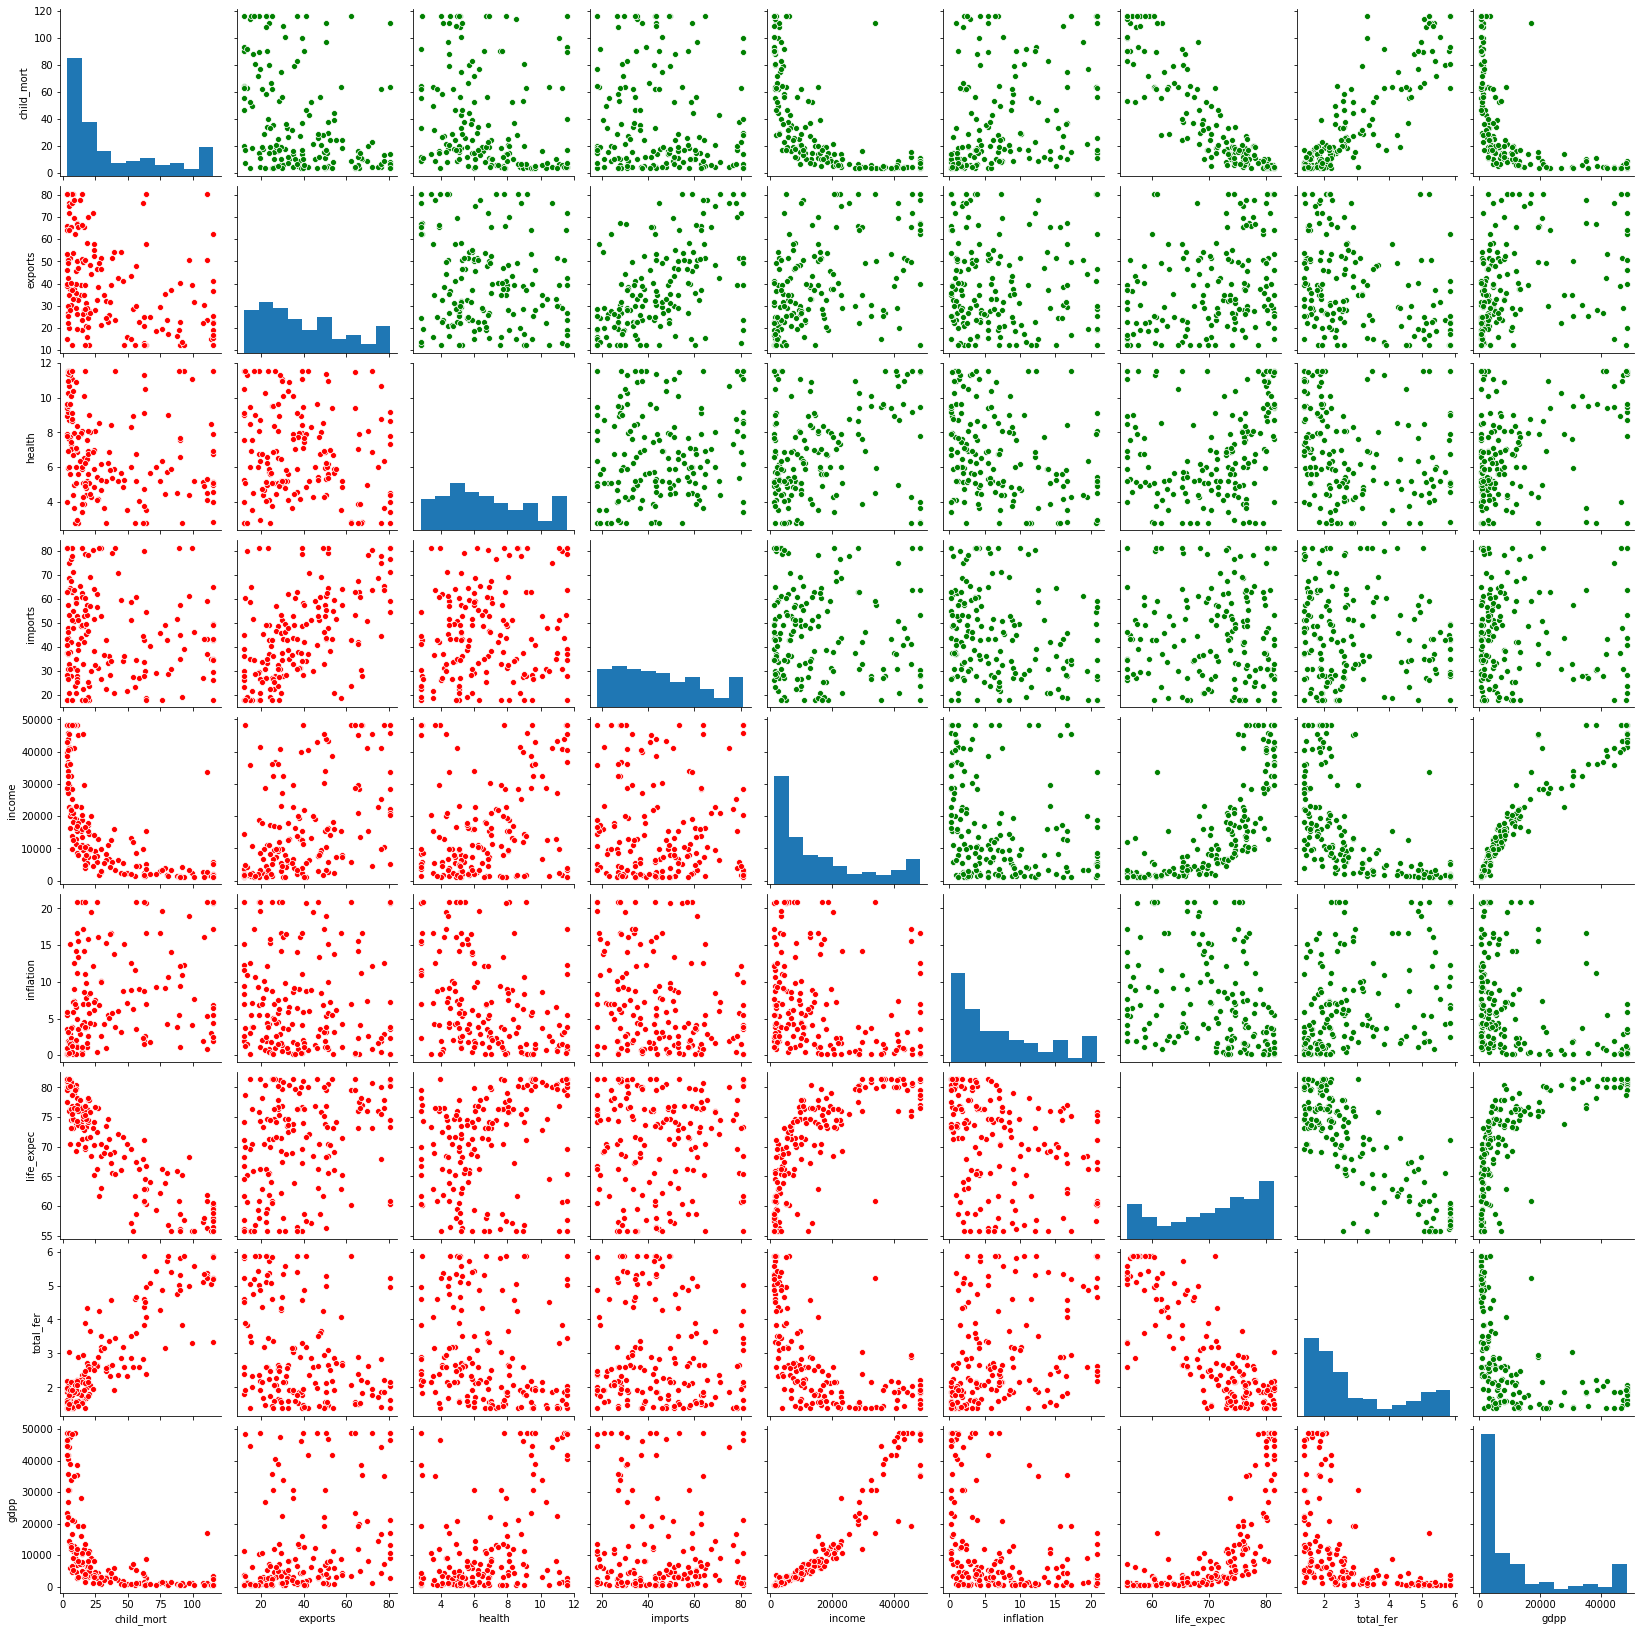

In [17]:
# pairplot of numerical variables
# sns.pairplot(data, vars=num_cols)
fig = sns.PairGrid(data[num_cols])
fig.map_upper(sns.scatterplot,color='green')
fig.map_lower(sns.scatterplot, color='red')
fig.map_diag(plt.hist)
plt.show()


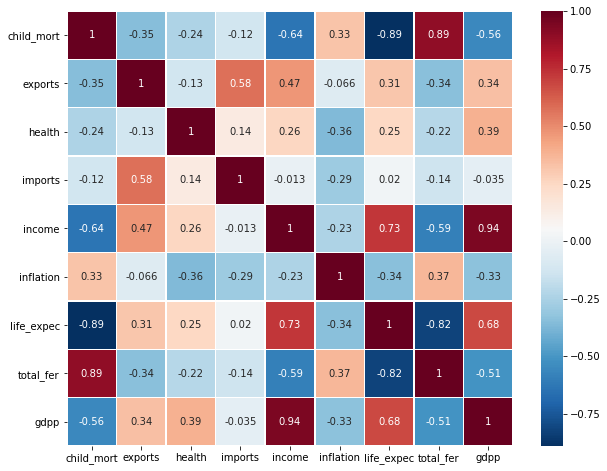

In [18]:
# Heatmap of numerical variables
# find correlation using heatmap
plt.figure(figsize=(10, 8))
pearsoncorr = data[num_cols].corr(method='pearson')
# display(pearsoncorr)
sns.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)
plt.show()

### Conclusion:
- From the pairplot and heatmap :
- There is strong positive(dark red color) correlation between : 
    - 1. If child_mort increases total_fer increases
    - 2. If income increases gdpp increases
- There is strong negative correlation(dark blue color) between : 
    - 1. If child_mort increases life_expec decreases
    - 2. If child_mort increases income decreases
- Since correlation exists between the attributes we will have to remove redundant features and select relevant features.

# Feature Transformation

### 1. Feature Scaling - Numerical Variables   

In [19]:

display("\n=====Before feature scaling=====\n", data.describe())

'\n=====Before feature scaling=====\n'

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,36.808623,39.310838,6.767419,45.364251,15755.491018,7.016075,70.830060,2.922389,12003.719162
std,36.193830,19.886059,2.529308,18.303537,14770.353771,6.271398,8.039216,1.438264,15154.443890
min,3.460000,12.120000,2.791000,18.130000,1213.000000,0.183400,55.780000,1.390000,465.900000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,116.000000,80.570000,11.570000,81.140000,48290.000000,20.870000,81.400000,5.861000,48610.000000


In [20]:

# from sklearn.preprocessing import StandardScaler
 
# Create a scaling object
# scaler = StandardScaler()
 
# Scale these variables using 'fit_transform'
# data[num_cols] = scaler.fit_transform(data[num_cols])
    

In [21]:
from sklearn.preprocessing import MinMaxScaler

# Create a scaling object
scaler = MinMaxScaler()

# Scale these variables using 'fit_transform'
data[num_cols] = scaler.fit_transform(data[num_cols])
    

In [22]:
    
display("\n=====After feature scaling=====\n", data.describe())


'\n=====After feature scaling=====\n'

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,0.296327,0.397236,0.452947,0.432221,0.308909,0.330295,0.587434,0.342740,0.239652
std,0.321609,0.290519,0.288109,0.290486,0.313749,0.303162,0.313787,0.321687,0.314773
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.042563,0.170636,0.242511,0.191557,0.045500,0.078631,0.371585,0.090584,0.017948
50%,0.140750,0.334259,0.401982,0.399460,0.185802,0.251689,0.676034,0.228137,0.087116
75%,0.521059,0.573119,0.661693,0.644660,0.458547,0.510794,0.820453,0.556922,0.282155
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


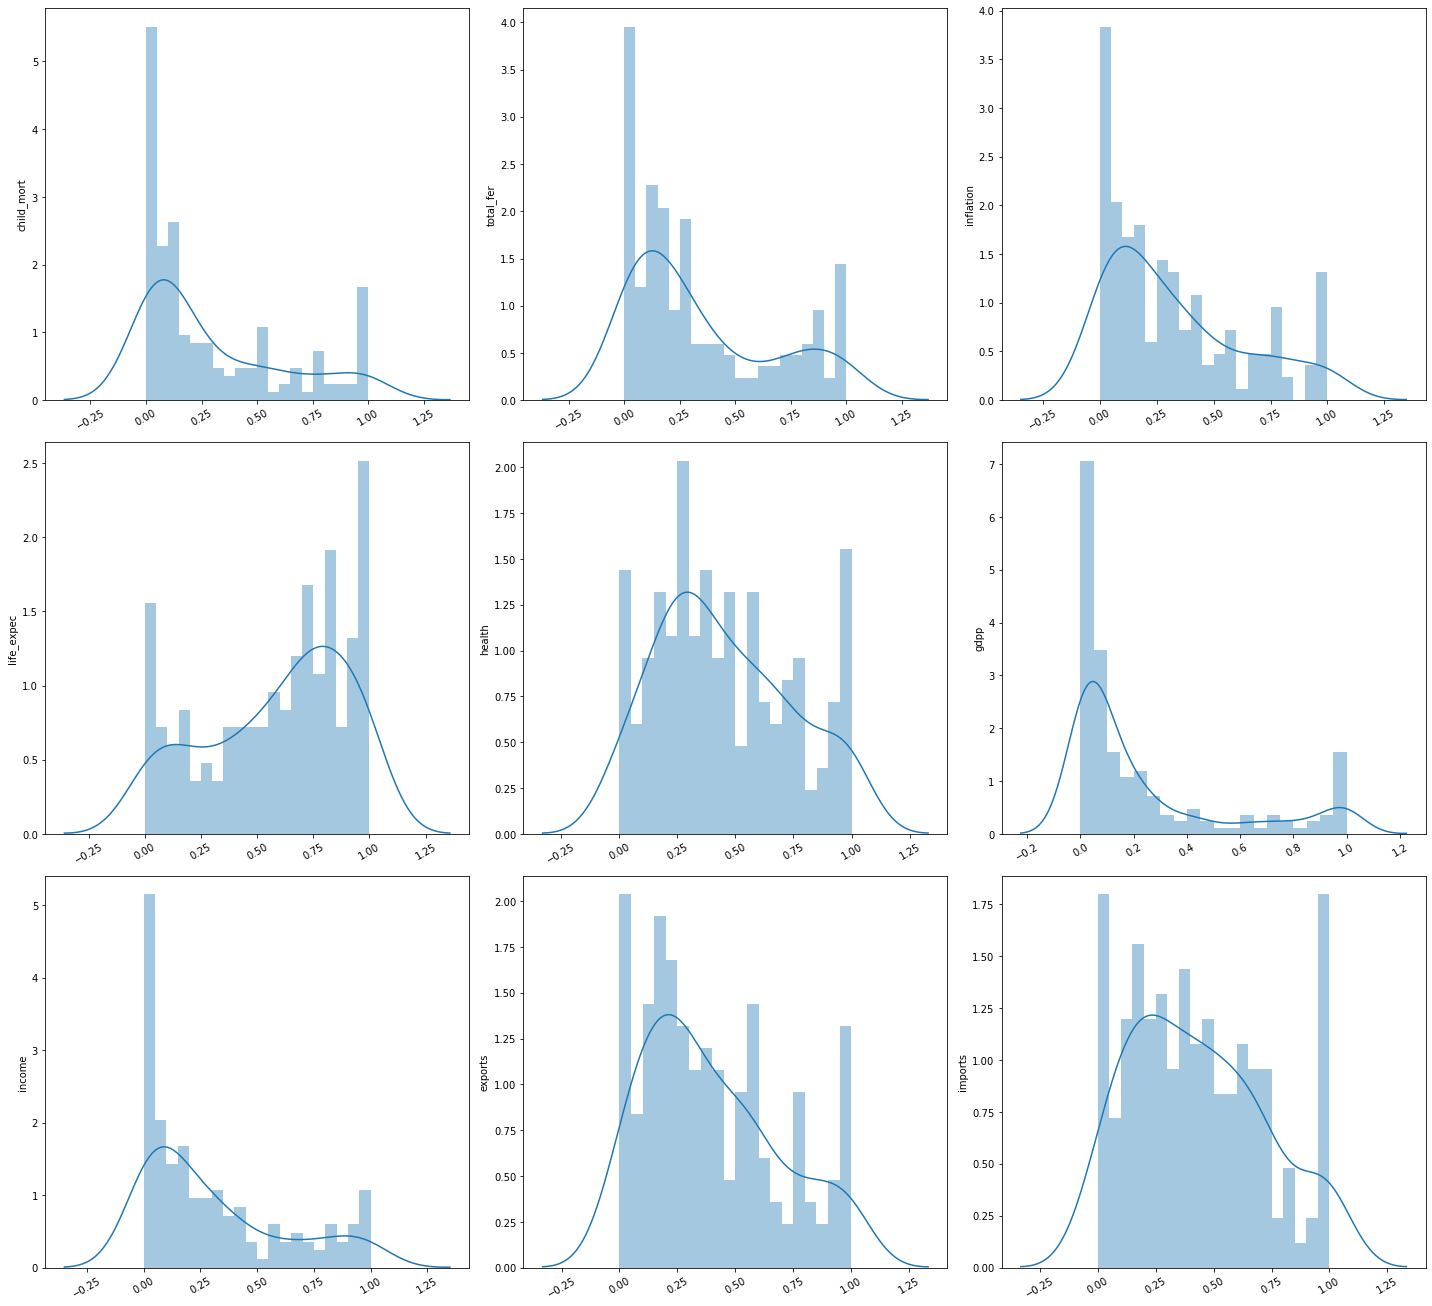

In [23]:
#After scaling:
# Find the countries with highest: Child Mortality Rate,Fertility Rate, Inflation
# Find the countries with lowest: Life Expectancy, Health, GDP,Income,Imports,Exports
cols=['child_mort','total_fer','inflation','life_expec','health','gdpp','income','exports','imports']

# Bin the data and plot the dist plot of the numerical terms
plt.figure(figsize=(20, 60))
i=1
sortAsc=False
for c in cols:
    ax2 = plt.subplot(10,3,i)
    if(i>3):
        sortAsc = True
    top10_df = data[['country',c]].sort_values(c, ascending = sortAsc).head(20)
#     sns.barplot(x='country', y=c, data= top10_df, ax = ax2)
    sns.distplot(data[c], bins = 20,ax=ax2)
    ax2.set(xlabel=None, ylabel=c)
    plt.xticks(rotation=30)
    i = i + 1

plt.tight_layout()
plt.show()

##### Conclusion:

- From the max/mean values in the columns there is lot of variation in the mean values of the columns.
- This may be because data in each col is measured in different units of measurement.
- However most ML algorithms would consider income more important than child_mort only because the values for income are larger and have higher variability from country to country. As k-means algorithm computes the Euclidean distance between the data points, it is important to ensure that the attributes with a larger range of values do not out-weight the attributes with smaller range. This is because the ML algorithms internally use SVD to compute the principal components and assume that the data is scaled and centred. Hence Feature Scaling is required so that all the cols are brought down in same range so that they can be compared with each other.
- There are two common ways of rescaling:
    - Standardisation (mean-0, sigma-1)    
        - We could have used StandardScaler class for this which implements standardization method to scale the numerical features. Standardization scales/shifts the values so that the features have a mean of 0 and standard deviation of 1. 
    - Min-Max scaling(Normalization)
        - However we have used MinMaxScaler because we do not want to assume that the shape of all the features follows a normal distribution. 
- We can clearly see mean,min,max,25%,50%,75% values have been normalized in comparable range.   


### 3. Assign feature and response variables


In [24]:
print(data.shape)

# Putting feature variable to X
X = data[num_cols]

# Putting response variable to y
y = data['country']

# display(X.head())
# display(y.head())

(167, 10)


##### Conclusion:
After feature scaling, we can now Identify feature and response variables

### 4. Feature Selection/Reduction 

##### Identify the important features

[0.11901598 0.12210233 0.11884251 0.11633309 0.11555674 0.11220098
 0.10137754 0.11154107 0.08302976]


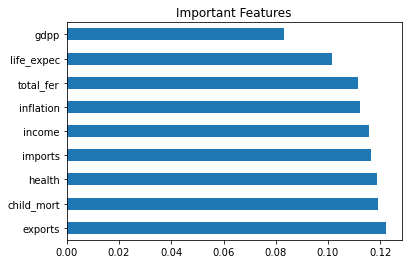

In [25]:
#top important features 

from sklearn.ensemble import ExtraTreesRegressor

model = ExtraTreesRegressor()
model.fit(X,data.index)
print(model.feature_importances_)

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title('Important Features')
plt.show()

##### Feature selection of relevant columns using correlation


In [26]:
# Find the highly correlated pairs using the correlation matrix
corr = X.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
is_corr_exists = False
correlated_features=set({})
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if abs(corr.iloc[i,j]) >= 0.8:
            if columns[j]:
                is_corr_exists = True
                columns[j] = False
                print(corr.columns[i],',',corr.columns[j],'=',corr.iloc[i,j])
                colname = corr.columns[j]
                correlated_features.add(colname)

correlated_features = list(correlated_features)
len(correlated_features)
print(correlated_features)

child_mort , life_expec = -0.8902009688632465
child_mort , total_fer = 0.892782059760353
income , gdpp = 0.9415138703300449
['life_expec', 'total_fer', 'gdpp']


Text(0.5, 1.0, 'After dropping features')

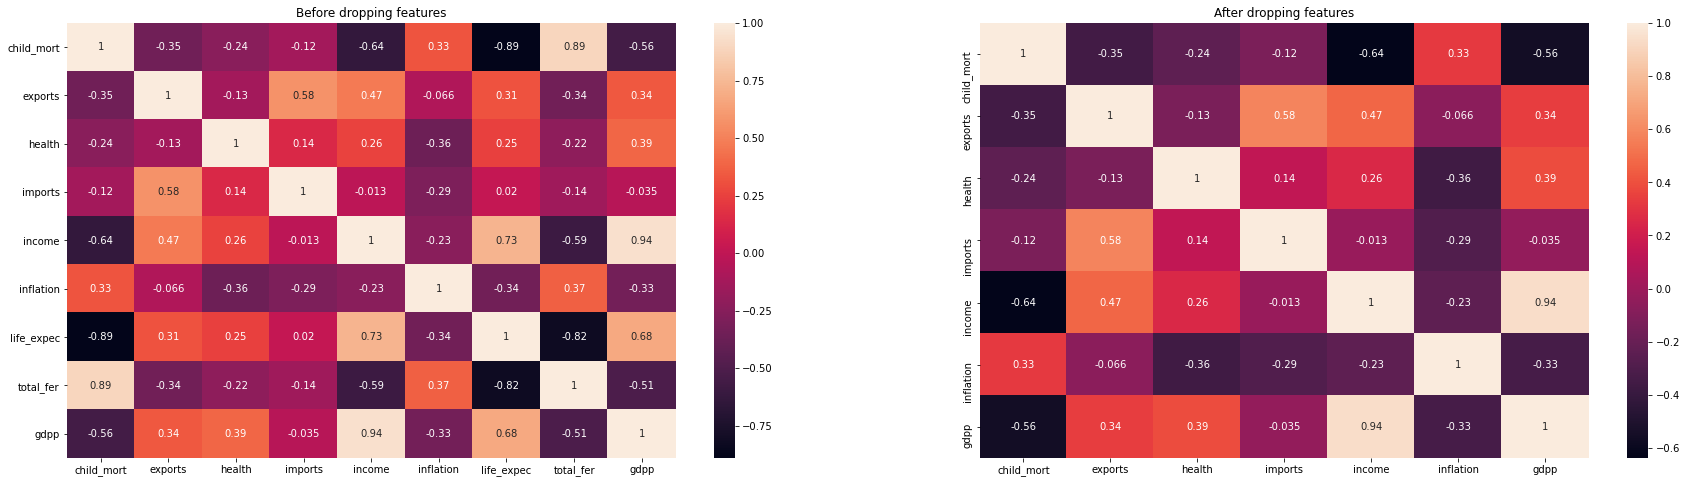

In [27]:
plt.figure(figsize = (30,8))

#Before dropping features
corr = X.corr()
plt.subplot(1,2,1)
sns.heatmap(corr,annot = True)
plt.title("Before dropping features")

#Drop the correlated cols
X.drop(labels=['total_fer', 'life_expec'], axis=1, inplace=True)

#After dropping features
corr = X.corr()
plt.subplot(1,2,2)
sns.heatmap(corr,annot = True)
plt.title("After dropping features")

##### Conclusion:
- As the number of features increases, the feature space becomes sparse.
- This sparsity makes it difficult for ML algorithms to find data objects near one another in higher-dimensional space.
- Feature Reduction reduces the number of features in the dataset by either removing or combining them.
- From correlation matrix and heatmap we can see many features have strong positive/negative correlation:
    - child_mort , life_expec = -0.8902009688632465
    - child_mort , total_fer = 0.892782059760353
    - income , gdpp = 0.9415138703300449
- We have identified the redundant column-pairs using correlation matrix. However by business knowledge we know that <b>we cannot remove income and gdpp from the dataset</b>. We will remove the other columns.
- We may think of removing any one of the column and retaining the other from the pair
- We see about 3 columns of the original features in the dataset. 
- After feature selection,  now <b>count of columns(features) is reduced from 9 to 6</b> Now no features have positive/negative correlation with each other.

# Hopkins test to confirm if data can be clustered

In [28]:
# Calculating Hopkins score to know whether the data is good for clustering or not.
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan

def hopkin_score(df):
    d = df.shape[1]
    n = len(df)
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(df.values)
 
    rand_df = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(df,axis=0),np.amax(df,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(df.iloc[rand_df[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    HS = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(HS):
        print(ujd, wjd)
        HS = 0
 
    return HS

hopkin_score(X)

0.7200834917215504

### Conclusion:

The Hopkins statisticgives a value which measures the cluster tendency, 
in other words: how well the data can be clustered.
- If the value is between (0.01, ...,0.3), the data is regularly spaced.
- If the value is around 0.5, it is random.
- If the value is between (0.7, ..., 0.99), it has a high tendency to cluster.

It acts as a statistical hypothesis test where the null hypothesis is that the data is generated by a Poisson point process and are thus uniformly randomly distributed. A value close to 1 tends to indicate the data is highly clustered, random data will tend to result in values around 0.5, and uniformly distributed data will tend to result in values close to 0.

Our dataset has <b>hopkins score > 0.70</b>, so our dataset has <b>good tendency to cluster</b>.

# Model Building

In [29]:
#Take backup before building model 
data_backup2 = data.copy()

In [30]:
# data = data_backup.copy()

### 1.   K- means Clustering

##### 1. Finding the Optimal Number of Clusters

In [31]:
# Choose the value of K - run thru clusters range 2 to 8 
# Silhouette score
# Elbow curve-ssd

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

ss = []
inertias = []
distortions=[]
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, max_iter=50,random_state= 0)
    kmeans.fit(data[num_cols])
    kmeans_cluster_labels= kmeans.labels_
    
    silhouette_avg_score = silhouette_score(data[num_cols],kmeans_cluster_labels )
    distortion_score = sum(np.min(cdist(data[num_cols], kmeans.cluster_centers_,'euclidean'), axis=1)) / X.shape[0]
    kmeans_inertia_score=kmeans.inertia_
    
    ss.append([k, silhouette_avg_score])   
    distortions.append([k,distortion_score])
    inertias.append([k,kmeans_inertia_score])
    
                       
silhouette_df = pd.DataFrame(ss,columns=['no_of_clusters','silhouette_score'])    
# silhouette_df=silhouette_df.sort_values(by='silhouette_score',ascending=False)
elbow_inertia_df = pd.DataFrame(inertias,columns=['no_of_clusters','kmeans_inertia'])
elbow_distortion_df = pd.DataFrame(distortions,columns=['no_of_clusters','distortion'])
elbows_df = silhouette_df
elbows_df = pd.merge(elbows_df, elbow_inertia_df, on='no_of_clusters')
elbows_df = pd.merge(elbows_df, elbow_distortion_df, on='no_of_clusters')
# display(elbow_distortion_df)
# display(elbow_inertia_df)
# display(silhouette_df)
elbows_df

,no_of_clusters,silhouette_score,kmeans_inertia,distortion
0,2,0.303989,89.723382,0.704426
1,3,0.290093,67.648104,0.606515
2,4,0.260983,58.159496,0.558409
3,5,0.251523,52.209888,0.527401
4,6,0.245815,47.941611,0.508943
5,7,0.250587,43.588196,0.485021


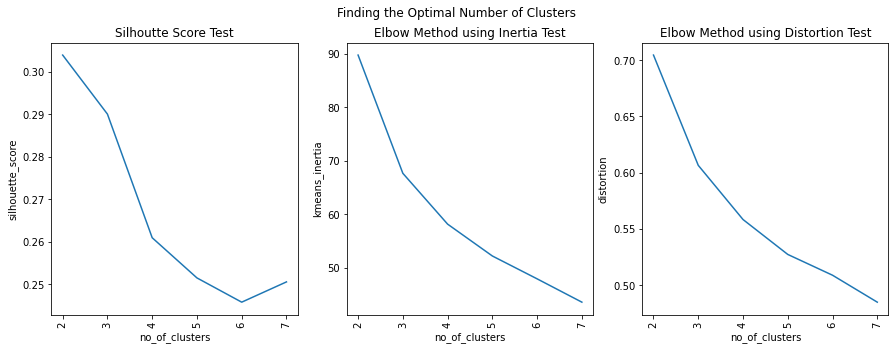

In [32]:
# Plot 
titles=['Silhoutte Score Test','Elbow Method using Inertia Test','Elbow Method using Distortion Test']
test_df_list=[silhouette_df,elbow_inertia_df,elbow_distortion_df]
plt.figure(figsize=(15, 5))
i=1
for df in test_df_list:
    ax2 = plt.subplot(1,3,i)
    sns.lineplot(x=df.columns[0],  y = df.columns[1], data = df,ax=ax2)
    plt.xticks(rotation=90)
    plt.title(titles[i-1])
    i = i + 1

plt.suptitle('Finding the Optimal Number of Clusters')
plt.show()

In [33]:
# Identify the elbow point programmatically:
# pip install kneed or conda install kneed
# ss = list(silhouette_df.silhouette_score)
# from kneed import KneeLocator
# kl = KneeLocator(range(2, 8), ss, curve="convex", direction="decreasing")
# print("Programmatically Optimum no of clusters = ",kl.elbow)

##### Conclusion:

For any unsupervised algorithm we have to determine the optimal number of clusters into which the data may be clustered. 
There are many ways to do that. 
These are often used as complementary evaluation techniques rather than one being preferred over the other. 

1.   SSE 
    - When you plot SSE as a function of the number of clusters, notice that SSE continues to decrease as you increase k.
    - As more centroids are added, the distance from each point to its closest centroid will decrease.
    - There’s a sweet spot where the SSE curve starts to bend known as the elbow point. 
    - The x-value of this point is thought to be a reasonable trade-off between error and number of clusters. 
    - To perform the elbow method, run several k-means, increment k with each iteration, and record the SSE
    - In this example, the elbow is located at x=3 or x=4 or x=5:

2. Elbow Curve to get the right number of Clusters
    - One of the most popular methods 
    - Two types :   
        - Distortion:
        It is calculated as the average of the squared distances
        from the cluster centers of the respective clusters. 
        Typically, the Euclidean distance metric is used.
        - Inertia:
        It is the sum of squared distances of samples to their closest cluster center.
        Inertia is the sum of squared error for each cluster. 
        Therefore the smaller the inertia the denser the cluster(closer together all the points are) 
        
    - To determine the optimal number of clusters, we have to select the value of k at the “elbow” ie the point after which the distortion/inertia start decreasing in a linear fashion. Thus for the given data, we conclude that the optimal number of clusters for the data is 3, 4 or 5.

3. Silhouette Analysis
    - Formula: <br/>
    silhouette score=(p−q)/max(p,q)<br/>
    where,<br/>
    p = is the mean distance to the points in the nearest cluster that the data point is not a part of<br/>
    q = is the mean intra-cluster distance to all the points in its own cluster.<br/>
    - A higher silhouette coefficient suggests better clusters
    - The silhouette coefficient is a measure of cluster cohesion and separation. It quantifies how well a data point fits into its assigned cluster based on two factors:
       - How close the data point is to other points in the cluster
       - How far away the data point is from points in other clusters
    - Silhouette coefficient values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters. The value of the silhouette score range lies between -1 to 1.
        - A score closer to 1 indicates that the data point is very similar to other data points in the cluster,
        - A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

    - In the scikit-learn implementation of the silhouette coefficient, the average silhouette coefficient of all the samples is summarized into one score.
    - The silhouette score() function needs a minimum of two clusters, or it will raise an exception.
    - A list holds the silhouette coefficients for each k
    - Plotting the average silhouette scores for each k shows that the best choice for k is 3 since it has the maximum score:

<b>Our approach:
- The maximum scores are for k=2. 
- However in real-world business it makes no sense to have only 2 clusters to represent the entire data. 
- The elbow extends from k=3 to k=5, and then it starts to flatten out. 
- We will check k-means for k=3,4,5 values </b>

##### 2. Cluster Profiling of k-means - Apply K-means with the identified no of k clusters

In [34]:
# Create df_list for 3,4,5 cluster labels
def create_cluster_df(k):
    data_new_df = data.copy()

    kmeans = KMeans(n_clusters=k, max_iter=50,random_state=100)
    kmeans.fit(data_new_df[num_cols])

    # Assign the label
    data_new_df['Cluster_Id'] = kmeans.labels_
    # display(data_new_df.head())
    return data_new_df
    
df_list = []
for k in range(3,6):
    df = create_cluster_df(k)
    df_list.append([k,df])
    
print('Cluster labels added')

Cluster labels added


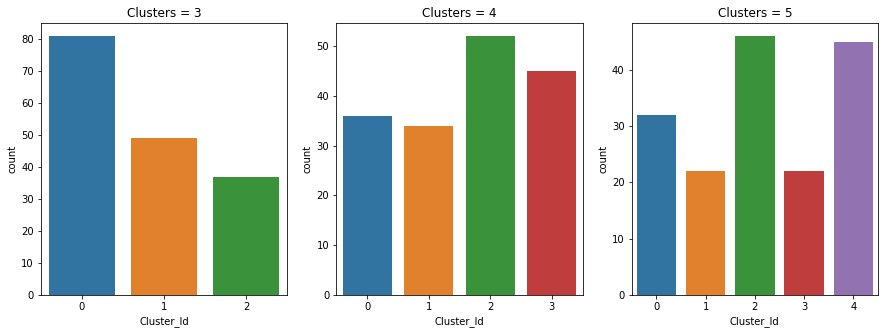

In [35]:
# Number of countries in each cluster
def plot_compare_country_counts(df_list):
    plt.figure(figsize=(15, 5))
    i = 1
    for x in df_list:
        k=x[0]
        data_new_df = x[1]
        #     print(data_new_df['Cluster_Id'].value_counts())
        plt.subplot(1,3,i)
        sns.countplot(data_new_df['Cluster_Id'])
        plt.title('Clusters = '+str(k))
        i=i+1
    plt.show()
        
plot_compare_country_counts(df_list)


##### Conclusion:

Approximately:

      k=3|k=4|k=5
- 0 = 0.80|0.35|0.32
- 1 = 0.50|0.28|0.22
- 2 = 0.38|0.50|0.50
- 3 = NA  |0.45|0.20
- 4 = NA  |NA  |0.50
<br/><br/>
- Clusters <b>k=3 and k=4 contain most evenly distributed</b> values in all clusters. 


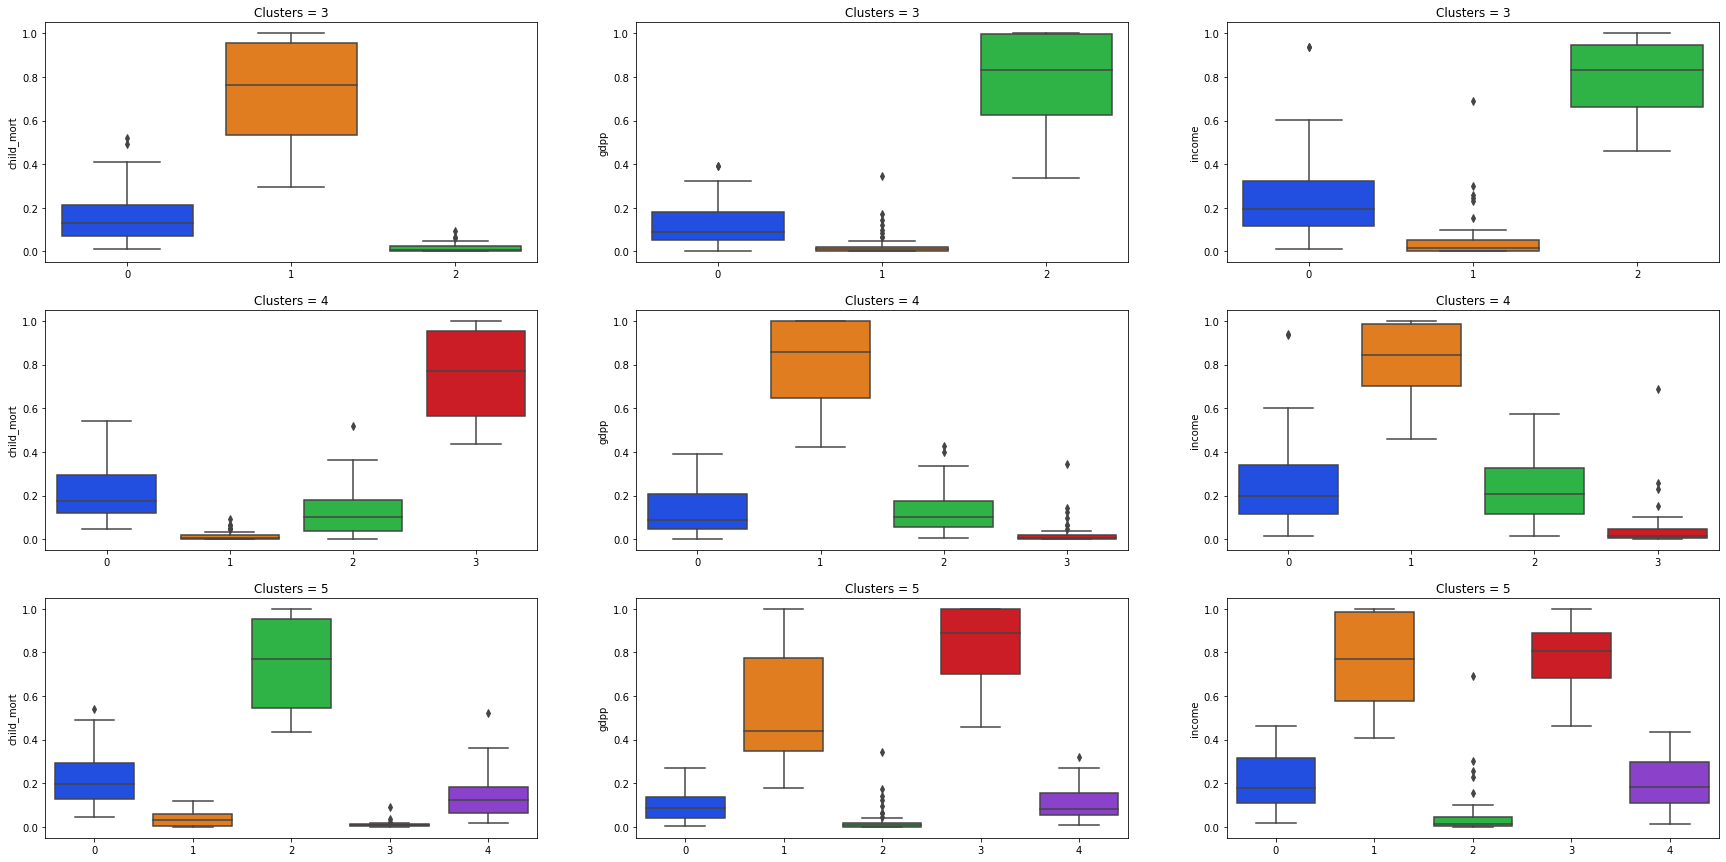

In [36]:
# Box plot on various variable Vs Cluster_Id
def plot_compare_economy_vars(df_list):
    plt.figure(figsize=(30, 15))
    cluster_cnt = len(df_list)
    cols=['child_mort','gdpp','income']
    i = 1    
    for x in df_list:
        k=x[0]
        data_new_df = x[1]
        for c in cols:
            plt.subplot(cluster_cnt, 3, i)
            sns.boxplot(x='Cluster_Id', y=c, data=data_new_df, palette="bright")
            plt.xlabel('')
            plt.title('Clusters = '+str(k))
            i = i+1
    plt.show()

    
plot_compare_economy_vars(df_list)



##### Conclusion
- when k=3, for cluster=1 : child_mort is highest, gdpp is lowest and income is lowest. So cluster=1 is of concern
- when k=4, for cluster=3 : child_mort is highest, gdpp is lowest and income is lowest. So cluster=3 is of concern
- when k=5, for cluster=2 : child_mort is highest, gdpp is lowest and income is lowest. So cluster=2 is of concern


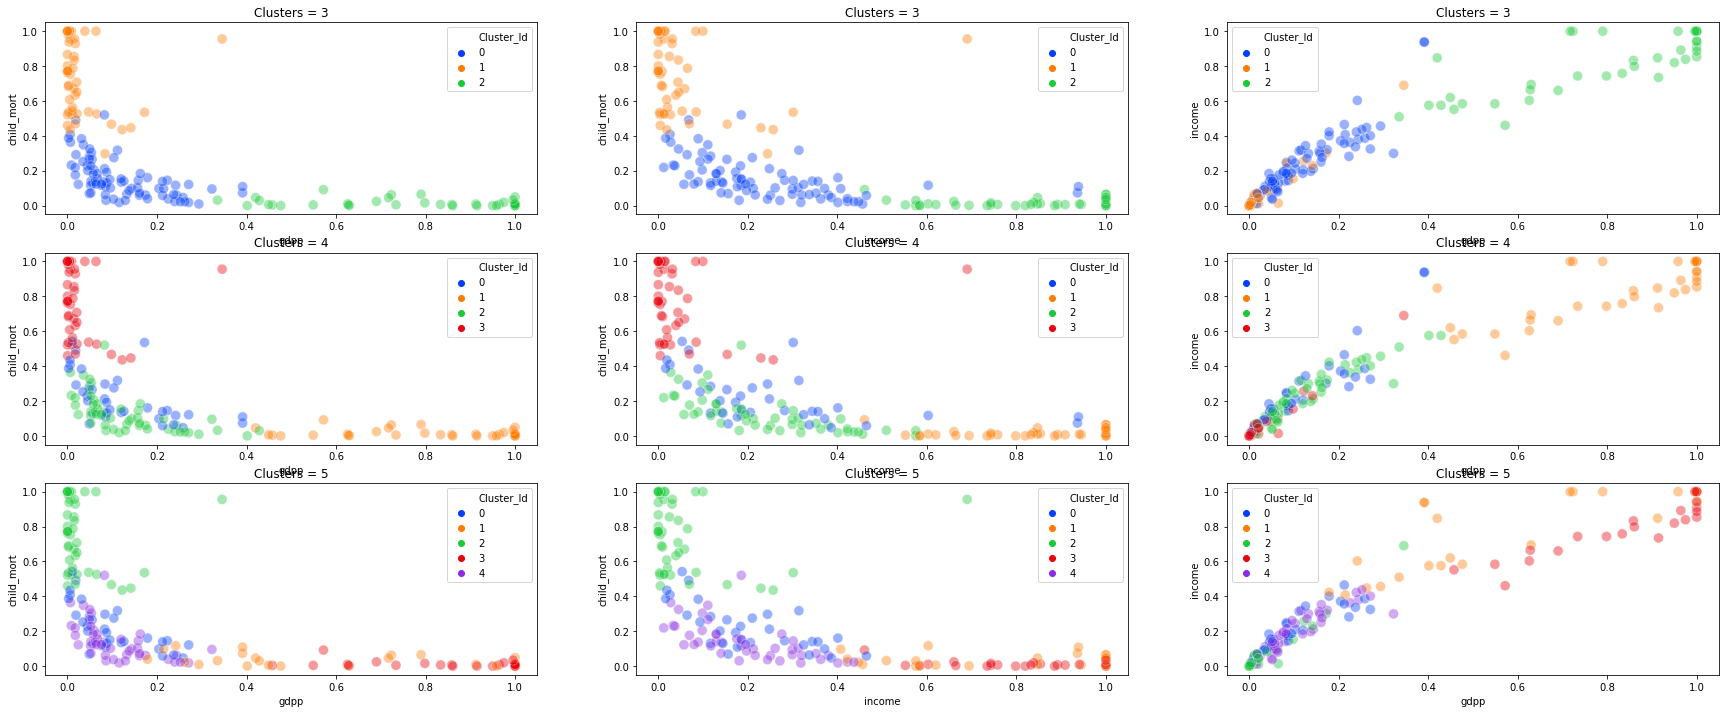

In [37]:

# Scatter plot on various variables to visualize the clusters based on them
def plot_compare_cluster_distribution(df_list):
    plt.figure(figsize=(30, 12))
    i=1
    cluster_cnt = len(df_list)
    for x in df_list:
        k=x[0]
        data_new_df = x[1]
        
        plt.subplot(cluster_cnt, 3, i)
        sns.scatterplot(x='gdpp', y='child_mort', hue='Cluster_Id',
                        data=data_new_df, legend='full', palette="bright", s=100, c='lightblue', alpha=.4)
        plt.title('Clusters = '+str(k))
        i=i+1
        plt.subplot(cluster_cnt, 3, i)
        sns.scatterplot(x='income', y='child_mort', hue='Cluster_Id',
                        data=data_new_df, legend='full', palette="bright", s=100, c='lightblue', alpha=.4)
        plt.title('Clusters = '+str(k))
        i=i+1
        plt.subplot(cluster_cnt, 3, i)
        sns.scatterplot(x='gdpp', y='income', hue='Cluster_Id',
                        data=data_new_df, legend='full', palette="bright", s=100, c='lightblue', alpha=.4)
        plt.title('Clusters = '+str(k))

        i=i+1
    plt.show()
plot_compare_cluster_distribution(df_list)

##### Conclusion:
- With k=3 clusters seem more correctly defined. 
- With k=4, in first plot child_mort vs gdpp clusters seem to overlap, and it defines few outliers well in other two plots. 
- With k=5 many clusters seem to overlap.
- So <b>k=3</b> seems our preferred choice.

In [38]:
# Compare means of the clusters
cols=['country','child_mort','income','gdpp']
sort_cols=['child_mort','income','gdpp']
sort_order= [False,True,True]

data_new_df=df_list[0][1]
display("k=3, Cluster_Id = 1")
# display(data_new_df[data_new_df['Cluster_Id'] == 1].sort_values(sort_cols,ascending =sort_order).tail())
display(data_new_df[data_new_df['Cluster_Id'] == 1].mean())

data_new_df=df_list[1][1]
display("k=4, Cluster_Id = 3")
# display(data_new_df[data_new_df['Cluster_Id'] == 3].sort_values(sort_cols,ascending =sort_order).tail())
display(data_new_df[data_new_df['Cluster_Id'] == 3].mean())


data_new_df=df_list[2][1]
display("k=5, Cluster_Id = 2")
# display(data_new_df[data_new_df['Cluster_Id'] == 2].sort_values(sort_cols,ascending =sort_order).tail())
display(data_new_df[data_new_df['Cluster_Id'] == 2].mean())


'k=3, Cluster_Id = 1'

child_mort    0.737780
exports       0.243437
health        0.398760
imports       0.371791
income        0.058298
inflation     0.471989
life_expec    0.188310
total_fer     0.767299
gdpp          0.029701
Cluster_Id    1.000000
dtype: float64

'k=4, Cluster_Id = 3'

child_mort    0.763166
exports       0.240519
health        0.410115
imports       0.384662
income        0.049754
inflation     0.458076
life_expec    0.167421
total_fer     0.790770
gdpp          0.026288
Cluster_Id    3.000000
dtype: float64

'k=5, Cluster_Id = 2'

child_mort    0.758212
exports       0.249767
health        0.402955
imports       0.376565
income        0.055224
inflation     0.465370
life_expec    0.169823
total_fer     0.786659
gdpp          0.029458
Cluster_Id    2.000000
dtype: float64


##### Conclusion:
- k=3
    - child_mort    0.737780
    - income        0.058298
    - gdpp          0.029701
    - Cluster_Id    1.000000

- k=4
    - child_mort=0.763166
    - income=0.049754
    - gdpp=0.026288
    - Cluster_Id=3.000000

- k=5
    - child_mort    0.758212
    - income        0.055224
    - gdpp          0.029458
    - Cluster_Id    2.000000
    
- We find that visually k=3 shows better distribution of data, and k=4 defines more correct average values. 

From the above 3 Iterations of K-Means, we could see that using 3 Clusters provided a better output in terms of a balanced cluster size. So we will consider the 'K-Means with 3 Clusters' as our FINAL MODEL


### 2. Hierarchical clustering (both single and complete linkage)


##### 1. Hierarchical clustering - single linkage
Here, the distance between 2 clusters is defined as the shortest distance between points in the two clusters.

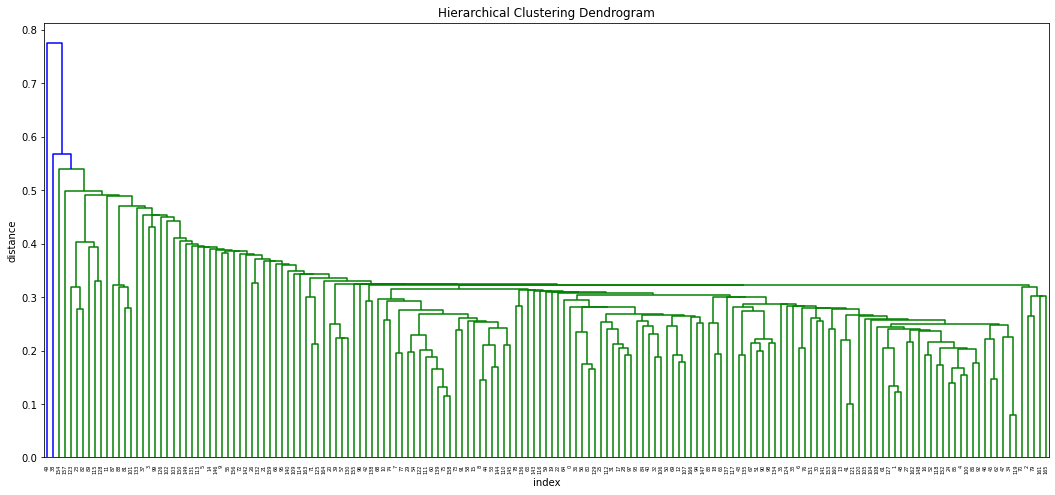

In [39]:
# single linkage: 
data_new_df = X.copy()

plt.figure(figsize=(18, 8))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('index')
plt.ylabel('distance')
mergings_s = linkage(data_new_df, method="single", metric='euclidean')
dendrogram(mergings_s)
plt.show()

##### 2. Hierarchical clustering - complete linkage
Here, the distance between 2 clusters is defined as the maximum distance between any 2 points in the clusters.


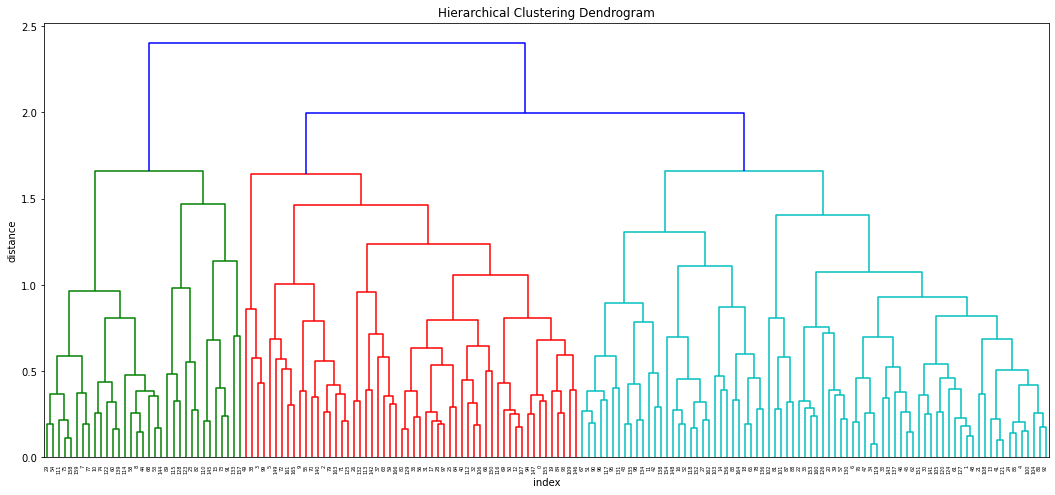

In [40]:
# complete linkage 
data_new_df = X.copy()

plt.figure(figsize=(18, 8))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('index')
plt.ylabel('distance')
mergings_c = linkage(data_new_df, method="complete", metric='euclidean')
dendrogram(mergings_c)
plt.show()

In [41]:
#Select clusters k=3, k=4, k=5 as we know these are otimal from elbow plots.
df_heirarchical_list=[]

for k in range(3,6):
    cluster_labels_3 = cut_tree(mergings_c, n_clusters=k).reshape(-1, )
    ngo_country_h = data.copy()
    ngo_country_h['Cluster_Id'] = cluster_labels_3
    df_heirarchical_list.append([k,ngo_country_h])

print('created heirarchical cut_tree')

created heirarchical cut_tree


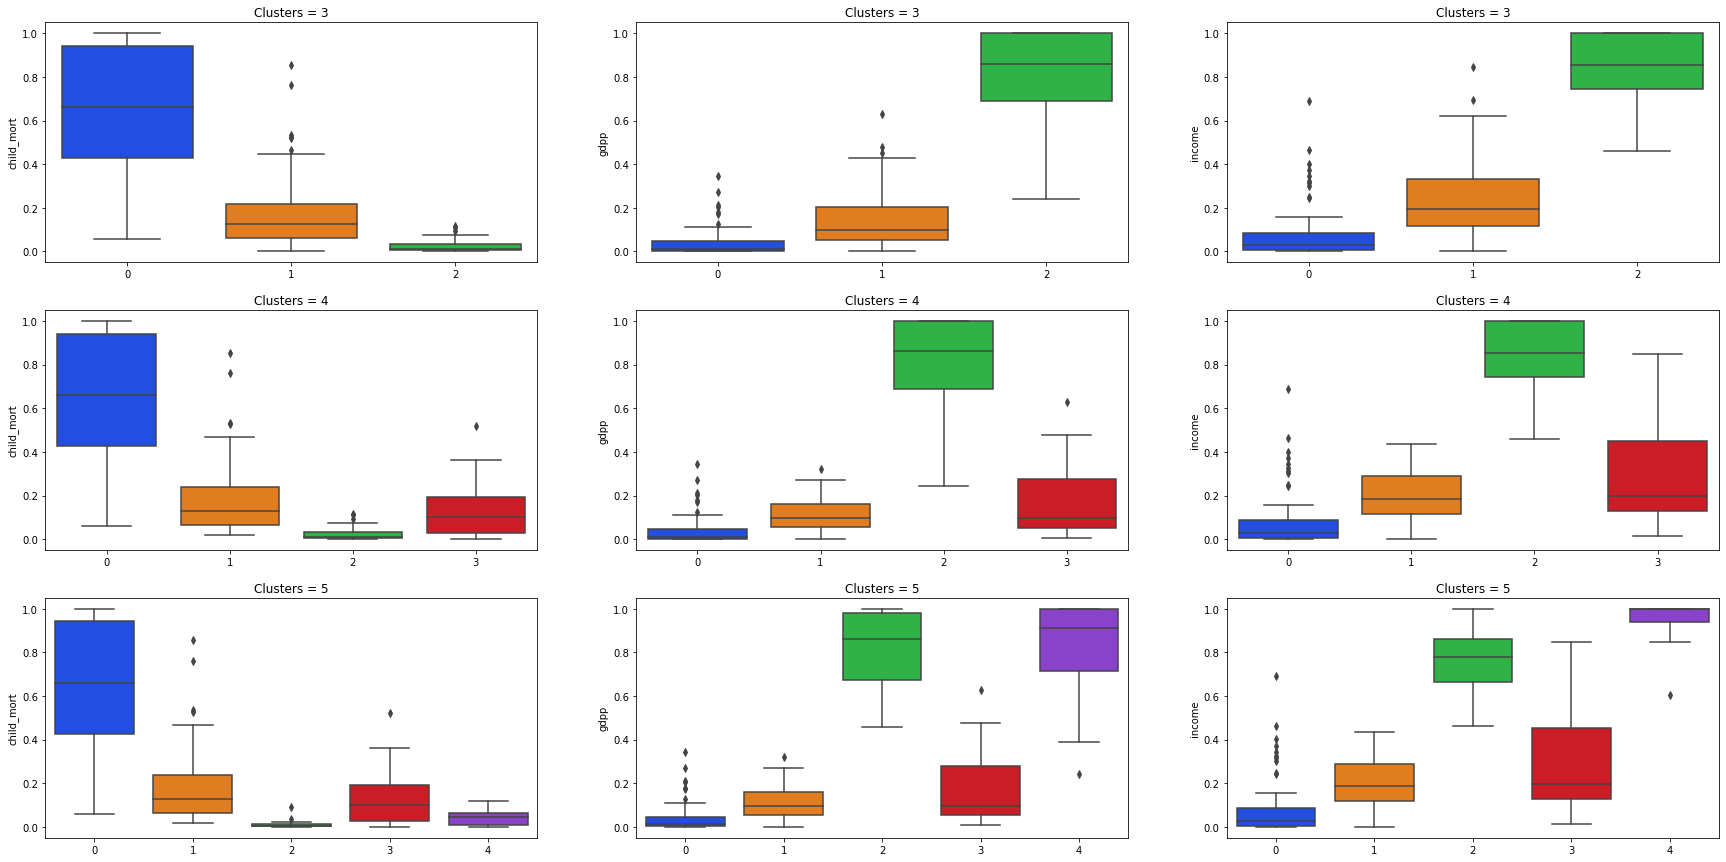

In [42]:
# Plot boxplot of features
plot_compare_economy_vars(df_heirarchical_list)


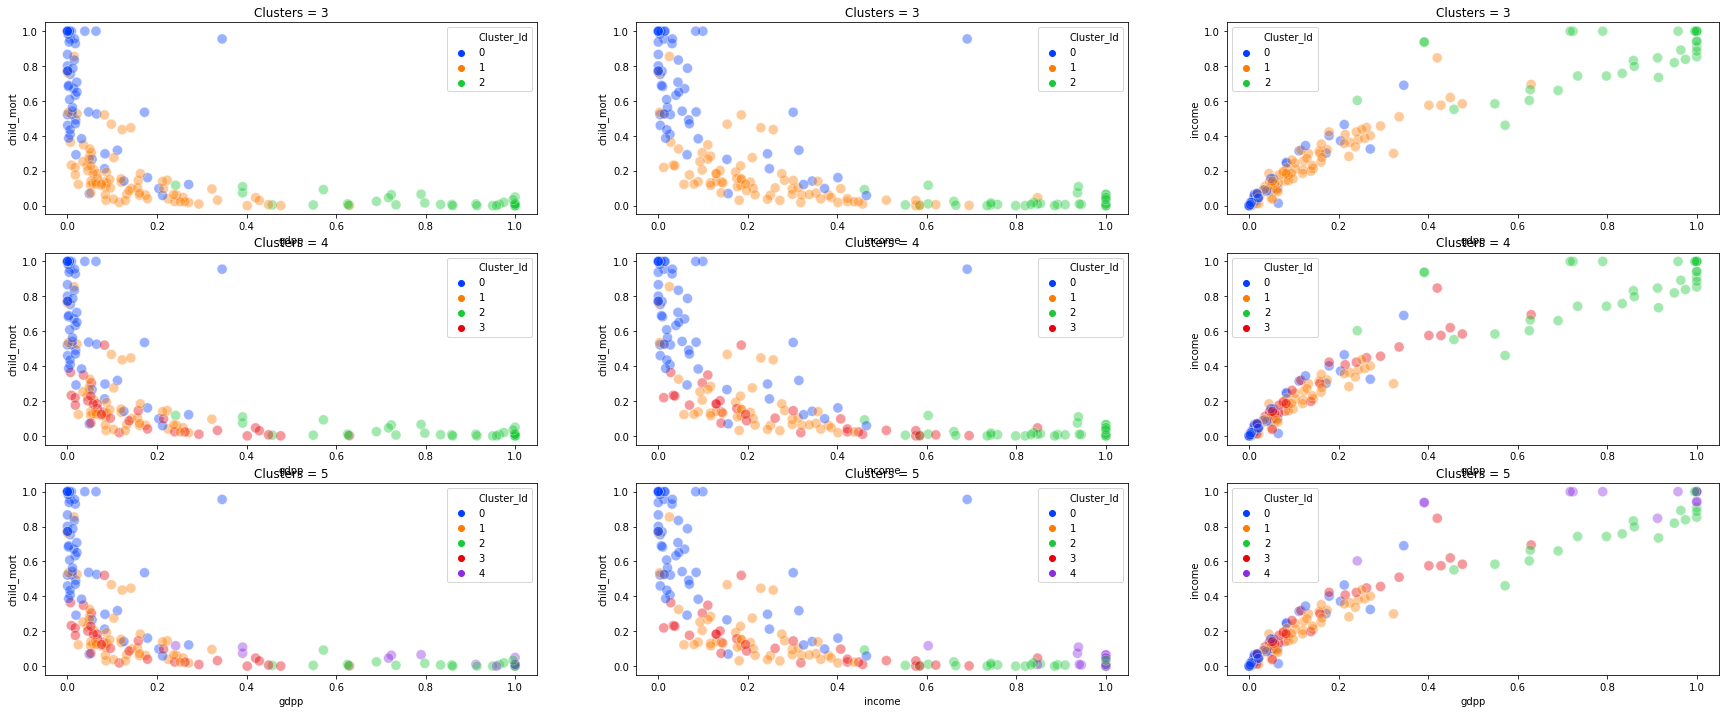

In [43]:
# Plot clusters distribution
plot_compare_cluster_distribution(df_heirarchical_list)

In [44]:
# Find cluster means by heirarchical clustering

cols=['country','child_mort','income','gdpp']
sort_cols=['child_mort','income','gdpp']
sort_order= [False,True,True]

data_new_df=df_heirarchical_list[0][1]
display("k=3, Cluster_Id = 1")
# display(data_new_df[data_new_df['Cluster_Id'] == 1].sort_values(sort_cols,ascending =sort_order).tail())
display(data_new_df[data_new_df['Cluster_Id'] == 1].mean())

data_new_df=df_heirarchical_list[1][1]
display("k=4, Cluster_Id = 3")
# display(data_new_df[data_new_df['Cluster_Id'] == 3].sort_values(sort_cols,ascending =sort_order).tail())
display(data_new_df[data_new_df['Cluster_Id'] == 3].mean())


data_new_df=df_heirarchical_list[2][1]
display("k=5, Cluster_Id = 2")
# display(data_new_df[data_new_df['Cluster_Id'] == 2].sort_values(sort_cols,ascending =sort_order).tail())
display(data_new_df[data_new_df['Cluster_Id'] == 2].mean())


'k=3, Cluster_Id = 1'

child_mort    0.168651
exports       0.457410
health        0.478959
imports       0.576152
income        0.241334
inflation     0.219425
life_expec    0.646390
total_fer     0.209326
gdpp          0.141862
Cluster_Id    1.000000
dtype: float64

'k=4, Cluster_Id = 3'

child_mort    0.132472
exports       0.723702
health        0.394637
imports       0.749871
income        0.298856
inflation     0.244556
life_expec    0.669739
total_fer     0.188455
gdpp          0.179215
Cluster_Id    3.000000
dtype: float64

'k=5, Cluster_Id = 2'

child_mort    0.012440
exports       0.302411
health        0.819569
imports       0.229773
income        0.766638
inflation     0.071303
life_expec    0.959992
total_fer     0.095169
gdpp          0.820373
Cluster_Id    2.000000
dtype: float64


##### Conclusion:
Hierarchical clustering involves creating clusters that have a predetermined ordering from top to bottom. 
For example, all files and folders on the hard disk are organized in a hierarchy. 
There are two types of hierarchical clustering,
1. Divisive
2. Agglomerative
    - 2.1 Single Linkage:
    In single linkage hierarchical clustering, the distance between two clusters is defined as the shortest distance between two points in each cluster.

    - 2.2 Complete Linkage:
In complete linkage hierarchical clustering, the distance between two clusters is defined as the longest distance between two points in each cluster. 

From the above Dendrograms, <b>'Complete Linkage' gives a better cluster formation</b>. So we will use Complete linkage output for our further analysis. We have cut the tree at height of 3, 4 and 5 clusters and see if it get any better cluster formation.

'k=3, Cluster_Id = 1'
- child_mort    0.149698
- income        0.330348
- gdpp          0.278207

'k=4, Cluster_Id = 3'
- child_mort    0.043412
- income        0.718317
- gdpp          0.546902

'k=5, Cluster_Id = 2'
- child_mort    0.831838
- income        0.229719
- gdpp          0.117909

- We find that optimum value <b>for Hierarchial clustering  that we select is k=3</b>.
- The clusters formed by K-means and Hierarchial clustering methods are different.
- The clusters formed in <b>K-means are better representation</b> as compared to Hierarchical. So, we will proceed with the clusters formed by K-means  and based on the information provided by the final clusters we will deduce the final list of countries which are in need of aid.

# Cluster Profiling and Final Analysis 
##### Selected cluster - k=3, cluster of concern = 1

In [45]:
# select("k=3, Cluster_Id = 1")
final_df=df_list[0][1]
display(final_df[final_df['Cluster_Id'] == 0].describe())
display(final_df[final_df['Cluster_Id'] == 1].describe())
display(final_df[final_df['Cluster_Id'] == 2].describe())


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster_Id
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.0
mean,0.156986,0.420588,0.389119,0.469984,0.237774,0.336917,0.668854,0.203865,0.122420,0.0
std,0.112659,0.261409,0.230993,0.296858,0.172293,0.282927,0.154519,0.154022,0.091881,0.0
min,0.009241,0.000000,0.000000,0.000000,0.012044,0.000000,0.231069,0.000000,0.002619,0.0
25%,0.071441,0.215924,0.235676,0.226472,0.116766,0.106185,0.570648,0.073809,0.052013,0.0
50%,0.130087,0.373703,0.351862,0.485161,0.195148,0.268125,0.699454,0.187877,0.087531,0.0
75%,0.211836,0.573850,0.517029,0.677194,0.324723,0.474539,0.793130,0.284053,0.178716,0.0
max,0.520171,1.000000,1.000000,1.000000,0.938611,1.000000,0.960968,0.659808,0.391203,0.0


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster_Id
count,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.0
mean,0.737780,0.243437,0.398760,0.371791,0.058298,0.471989,0.188310,0.767299,0.029701,1.0
std,0.210280,0.246409,0.289302,0.253506,0.116794,0.326828,0.167701,0.213859,0.060089,0.0
min,0.297139,0.000000,0.000000,0.000000,0.000000,0.033916,0.000000,0.228137,0.000000,1.0
25%,0.535276,0.063988,0.195808,0.182035,0.003760,0.191747,0.039813,0.666518,0.001809,1.0
50%,0.762751,0.170636,0.326803,0.351849,0.015230,0.422331,0.168618,0.818609,0.008954,1.0
75%,0.955571,0.363477,0.583096,0.499445,0.053253,0.793586,0.313037,0.932677,0.020648,1.0
max,1.000000,1.000000,1.000000,1.000000,0.690082,1.000000,0.597970,1.000000,0.345507,1.0


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster_Id
count,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.000000,37.0
mean,0.016744,0.549796,0.664439,0.429580,0.796527,0.128149,0.937760,0.084509,0.774337,2.0
std,0.022282,0.314690,0.305699,0.315261,0.168847,0.184571,0.074735,0.078752,0.220348,0.0
min,0.000000,0.004091,0.000000,0.000000,0.460671,0.000000,0.703357,0.000000,0.335121,2.0
25%,0.001244,0.259752,0.567149,0.164577,0.660344,0.008102,0.925839,0.011183,0.625915,2.0
50%,0.006575,0.556318,0.753958,0.358197,0.832402,0.047209,0.957065,0.100649,0.833624,2.0
75%,0.024347,0.807597,0.900900,0.710522,0.944984,0.166127,1.000000,0.125252,0.995638,2.0
max,0.091878,1.000000,1.000000,1.000000,1.000000,0.798420,1.000000,0.366808,1.000000,2.0


In [46]:
final_df=df_list[0][1]
display(final_df[final_df['Cluster_Id'] == 0].head(10))
display(final_df[final_df['Cluster_Id'] == 1].head(10))
display(final_df[final_df['Cluster_Id'] == 2].head(10))


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster_Id
1,Albania,0.116758,0.231994,0.428181,0.483574,0.185165,0.208183,0.800937,0.058153,0.075276,0
2,Algeria,0.211836,0.383930,0.157079,0.210601,0.248253,0.769416,0.808743,0.335495,0.082961,0
4,Antigua and Barbuda,0.060778,0.487655,0.368949,0.647040,0.379952,0.060745,0.820453,0.165511,0.243729,0
5,Argentina,0.098098,0.099050,0.604739,0.000000,0.371455,1.000000,0.781421,0.219190,0.204264,0
6,Armenia,0.130087,0.126808,0.183278,0.431201,0.116554,0.366740,0.683841,0.067099,0.057205,0
9,Azerbaijan,0.317576,0.616216,0.351862,0.040787,0.314102,0.658233,0.519906,0.118542,0.111625,0
12,Bangladesh,0.408210,0.056684,0.083039,0.058245,0.026064,0.336285,0.570648,0.210244,0.006067,0
13,Barbados,0.095433,0.400000,0.589931,0.485161,0.299233,0.006652,0.816550,0.087229,0.322658,0
14,Belarus,0.018127,0.573850,0.321107,0.735915,0.318351,0.721075,0.570648,0.022366,0.115572,0
16,Belize,0.136307,0.673192,0.274405,0.624821,0.141619,0.046242,0.609680,0.295236,0.080469,0


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster_Id
0,Afghanistan,0.770748,0.000000,0.545506,0.424853,0.008433,0.447468,0.016393,0.990830,0.001809,1
3,Angola,1.000000,0.733090,0.006721,0.393112,0.099560,1.000000,0.168618,1.000000,0.063644,1
17,Benin,0.955571,0.170636,0.149106,0.302650,0.012894,0.033916,0.234973,0.887945,0.006067,1
21,Botswana,0.435756,0.459898,0.627520,0.526424,0.256750,0.422331,0.051522,0.333259,0.122219,1
25,Burkina Faso,1.000000,0.103433,0.449823,0.182035,0.004609,0.320333,0.082748,1.000000,0.002266,1
26,Burundi,0.800960,0.000000,1.000000,0.334391,0.000000,0.585722,0.074941,1.000000,0.000000,1
28,Cameroon,0.928914,0.147261,0.266431,0.140771,0.030737,0.083465,0.059329,0.832029,0.017533,1
31,Central African Republic,1.000000,0.000000,0.135437,0.132836,0.000000,0.088299,0.000000,0.854395,0.000000,1
32,Chad,1.000000,0.360555,0.198086,0.402635,0.015230,0.300030,0.028103,1.000000,0.008954,1
36,Comoros,0.752977,0.063988,0.195808,0.532773,0.004185,0.178212,0.395004,0.751510,0.006296,1


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster_Id
7,Australia,0.011907,0.112199,0.676501,0.043961,0.853644,0.047209,1.000000,0.120778,1.000000,2
8,Austria,0.007464,0.572389,0.935072,0.470878,0.891879,0.033336,0.964871,0.011183,0.964482,2
10,Bahamas,0.091878,0.334259,0.580818,0.405809,0.460671,0.000000,0.703357,0.105122,0.571910,2
11,Bahrain,0.045673,0.838276,0.248206,0.520076,0.847271,0.350787,0.789227,0.172221,0.420282,2
15,Belgium,0.009241,0.939080,0.900900,0.897794,0.847271,0.082014,0.945355,0.105122,0.912554,2
23,Brunei,0.062556,0.807597,0.005582,0.156642,1.000000,0.798420,0.832162,0.100649,0.723538,2
29,Canada,0.019015,0.248064,0.969245,0.204253,0.838775,0.129872,0.996097,0.053679,0.974867,2
42,Cyprus,0.001244,0.556318,0.362114,0.624821,0.694331,0.088299,0.941452,0.006710,0.630069,2
43,Czech Republic,0.000000,0.787144,0.579679,0.710522,0.575377,0.000000,0.847775,0.026840,0.401588,2
44,Denmark,0.005687,0.560701,0.980636,0.404222,0.908873,0.146791,0.925839,0.107359,1.000000,2


##### Conclusion:
- Cluster_Id = 2 has developed countries like Australia, Austria which have low child_mort and high income
- Cluster_Id = 1 has undeveloped countries like Afghanistan, Burundi with very high child_mort and low income 
- Cluster_Id = 0 has developing countries like Algeria, Bangladesh with very lower child_mort and low income and high inflation.


,child_mort,income,gdpp
Cluster_Id,,,
Developing,0.156986,0.237774,0.122420
Underdeveloped,0.737780,0.058298,0.029701
Developed,0.016744,0.796527,0.774337


<Figure size 576x360 with 0 Axes>

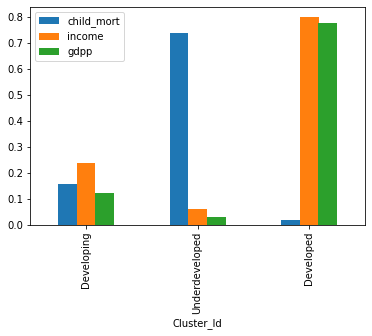

In [47]:
# select k=3, compare Cluster_Id = 1 with others 
final_df=df_list[0][1]

def rename_col(x):
    if x == '0':
        return 'Developing Countries'
    elif x == '1':
        return 'Underdeveloped Countries'
    else:
        return 'Developed Countries'
plt.figure(figsize=(8, 5))
plot_df=final_df[['child_mort','income','gdpp','Cluster_Id']].copy()
plot_df=plot_df.groupby('Cluster_Id').mean().reset_index()
plot_df['Name'] ='1'
plot_df['Name'] = np.where(plot_df.Cluster_Id == 0,'Developing',plot_df.Name)
plot_df['Name'] = np.where(plot_df.Cluster_Id == 1,'Underdeveloped',plot_df.Name)
plot_df['Name'] = np.where(plot_df.Cluster_Id == 2,'Developed',plot_df.Name)
plot_df = plot_df.drop('Cluster_Id',axis=1)
plot_df.columns=['child_mort','income','gdpp','Cluster_Id']
plot_df = plot_df.set_index('Cluster_Id')
display(plot_df)
plot_df.plot.bar()


##### Conclusion:
Final Cluster: 
Based on the above interpretation of the cluster,
we now rename all the clusters accordingly. 
The Cluster 2 now becomes 'Under Developed Countries', 
which will be of our interest. 


In [48]:
# select("k=3, Cluster_Id = 1")

final_df=df_list[0][1]
display(final_df['Cluster_Id'].value_counts())
final_df = final_df[final_df['Cluster_Id'] == 1].copy()
final_df = final_df[['country', 'child_mort', 'income', 'gdpp']]
final_df.sort_values([ 'gdpp', 'income','child_mort'], ascending=[True, True, False]).head()

0    81
1    49
2    37
Name: Cluster_Id, dtype: int64

,country,child_mort,income,gdpp
31,Central African Republic,1.000000,0.0,0.0
37,"Congo, Dem. Rep.",1.000000,0.0,0.0
112,Niger,1.000000,0.0,0.0
106,Mozambique,0.866714,0.0,0.0
26,Burundi,0.800960,0.0,0.0


##### Conclusion :
We have selected the final cluser with below distribution of data points:
- 0=81
- 1=49
- 2=37

Text(0.5, 1.0, 'Child Mortality')

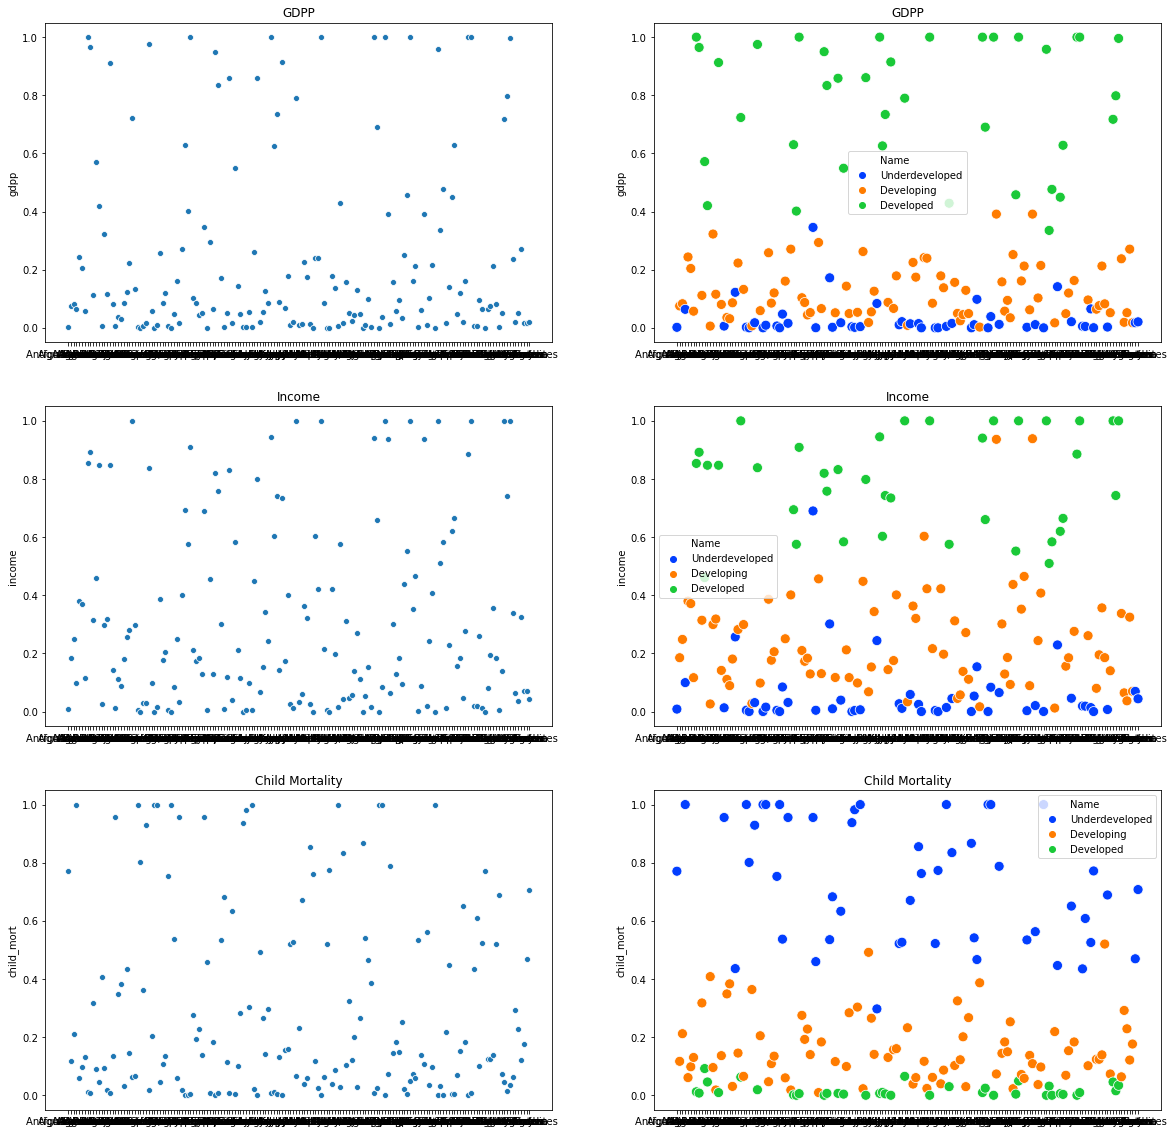

In [49]:
# Plot Raw data vs Clustered data
final_df=df_list[0][1].copy()
final_df=final_df[['country','Cluster_Id']]
plot_df = data.copy()
plot_df=pd.merge(plot_df,final_df,on='country' )
plot_df['Name'] ='1'
plot_df['Name'] = np.where(plot_df.Cluster_Id == 0,'Developing',plot_df.Name)
plot_df['Name'] = np.where(plot_df.Cluster_Id == 1,'Underdeveloped',plot_df.Name)
plot_df['Name'] = np.where(plot_df.Cluster_Id == 2,'Developed',plot_df.Name)
plot_df = plot_df.drop('Cluster_Id',axis=1)
# display(plot_df)

plt.figure(figsize=(20, 20))
plt.subplot(3, 2, 1)
sns.scatterplot(x='country', y ='gdpp',data=plot_df)
plt.xlabel('')
plt.title('GDPP')

plt.subplot(3, 2, 2)
sns.scatterplot(x='country', y ='gdpp', data=plot_df, hue='Name', legend='full', palette="bright", s=100,
                c='lightblue')
plt.xlabel('')
plt.title('GDPP')

plt.subplot(3, 2, 3)
sns.scatterplot(x='country', y ='income', data=plot_df)
plt.xlabel('')
plt.title('Income')

ax2=plt.subplot(3, 2, 4)
sns.scatterplot(x='country', y ='income', data=plot_df, hue='Name', legend='full', palette="bright", s=100,
                c='lightblue')
plt.xlabel('')
plt.title('Income')

plt.subplot(3, 2, 5)
sns.scatterplot(x='country', y ='child_mort', data=plot_df)
plt.xlabel('')
plt.title('Child Mortality')

plt.subplot(3, 2, 6)
sns.scatterplot(x='country', y ='child_mort', data=plot_df, hue='Name', legend='full', palette="bright", s=100,
                c='lightblue')
plt.xlabel('')
plt.title('Child Mortality')



##### Conclusion:
Data distribution - raw data and clustered data

In [50]:
# Compare 

final_df=df_list[0][1].copy()
final_df=final_df[['country','Cluster_Id']]
plot_df = data_backup1.copy()
plot_df=pd.merge(plot_df,final_df,on='country' )
plot_df['Name'] ='1'
plot_df['Name'] = np.where(plot_df.Cluster_Id == 0,'Developing',plot_df.Name)
plot_df['Name'] = np.where(plot_df.Cluster_Id == 1,'Underdeveloped',plot_df.Name)
plot_df['Name'] = np.where(plot_df.Cluster_Id == 2,'Developed',plot_df.Name)
plot_df = plot_df.drop('Cluster_Id',axis=1)
plot_df=plot_df.drop('country',axis=1)
# display(p1)
# p1.describe()
plot_df = plot_df.rename(columns = {'Name':'Cluster_Id'})
plot_df = plot_df.groupby(['Cluster_Id']).mean()
display(plot_df)







,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
Cluster_Id,,,,,,,,,
Developed,5.237838,58.097297,8.782973,51.281081,45056.756757,2.588432,79.956757,1.755676,42102.702703
Developing,21.127160,41.117037,6.235062,47.967901,12406.666667,7.646037,72.916049,2.296914,6359.703704
Underdeveloped,91.551020,28.267735,6.290000,41.793182,3900.469388,11.927857,59.555102,4.924490,1879.142857


Text(0.5, 0, '')

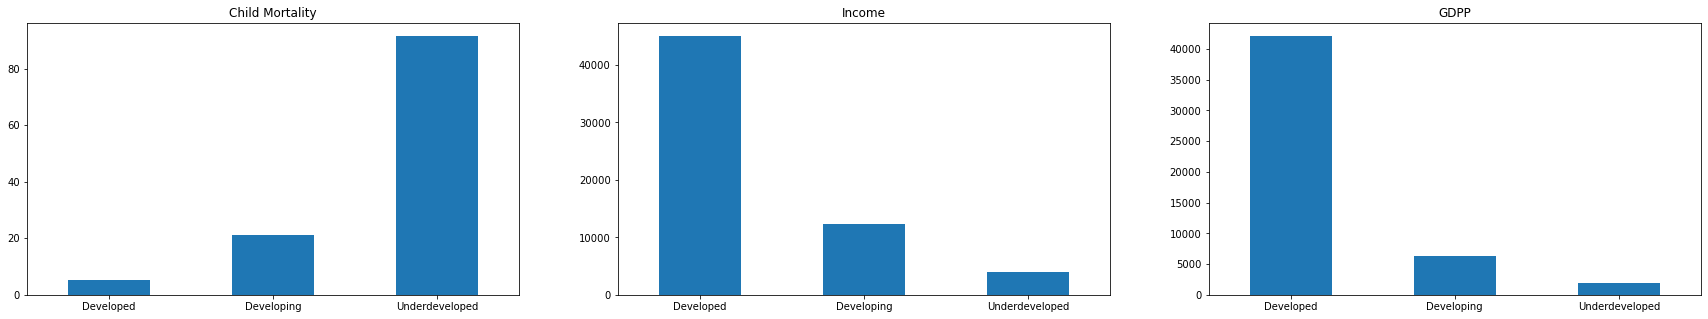

In [51]:
# Compare 

final_df=df_list[0][1].copy()
final_df=final_df[['country','Cluster_Id']]
plot_df = data_backup1.copy()
plot_df=pd.merge(plot_df,final_df,on='country' )
plot_df['Name'] ='1'
plot_df['Name'] = np.where(plot_df.Cluster_Id == 0,'Developing',plot_df.Name)
plot_df['Name'] = np.where(plot_df.Cluster_Id == 1,'Underdeveloped',plot_df.Name)
plot_df['Name'] = np.where(plot_df.Cluster_Id == 2,'Developed',plot_df.Name)
plot_df = plot_df.drop('Cluster_Id',axis=1)
plot_df=plot_df.drop('country',axis=1)
# display(p1)
# p1.describe()
plot_df = plot_df.rename(columns = {'Name':'Cluster_Id'})
plot_df = plot_df.groupby(['Cluster_Id']).mean()
# display(plot_df)

# plot_df=plot_df.reset_index()
p1=plot_df[['child_mort','income','gdpp']]
# display(p1)
plt.figure(figsize=(30, 5))
plt.subplot(1, 3, 1)
p1['child_mort'].plot.bar()
plt.title('Child Mortality')
plt.xticks(rotation=0)
plt.xlabel('')

plt.subplot(1, 3, 2)
p1['income'].plot.bar()
plt.title('Income')
plt.xticks(rotation=0)
plt.xlabel('')


plt.subplot(1, 3, 3)
p1['gdpp'].plot.bar()
plt.title('GDPP')
plt.xticks(rotation=0)
plt.xlabel('')






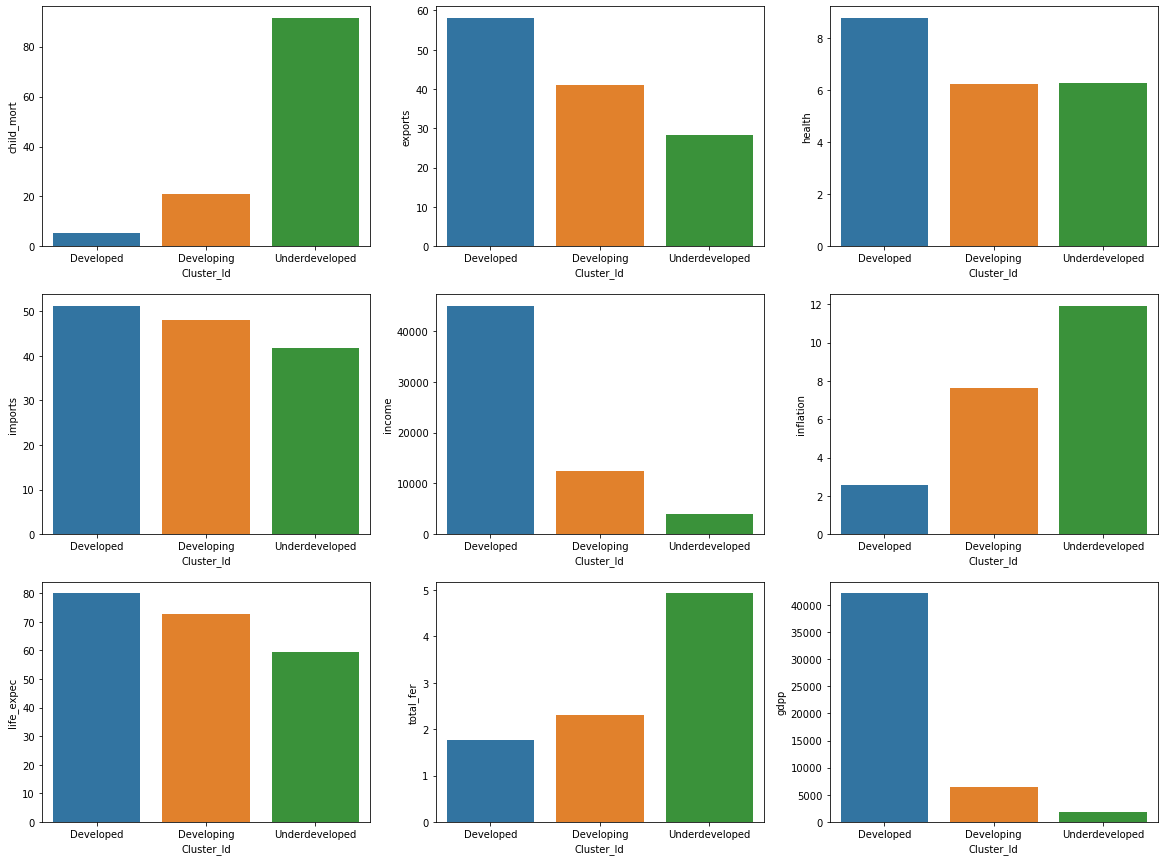

In [52]:
#Analyse all features of selected k=3 
# Compare 

final_df=df_list[0][1].copy()
final_df=final_df[['country','Cluster_Id']]
plot_df = data_backup1.copy()
plot_df=pd.merge(plot_df,final_df,on='country' )
plot_df['Name'] ='1'
plot_df['Name'] = np.where(plot_df.Cluster_Id == 0,'Developing',plot_df.Name)
plot_df['Name'] = np.where(plot_df.Cluster_Id == 1,'Underdeveloped',plot_df.Name)
plot_df['Name'] = np.where(plot_df.Cluster_Id == 2,'Developed',plot_df.Name)
plot_df = plot_df.drop('Cluster_Id',axis=1)
plot_df=plot_df.drop('country',axis=1)
plot_df = plot_df.rename(columns = {'Name':'Cluster_Id'})
plot_df = plot_df.groupby(['Cluster_Id']).mean()

plt.figure(figsize=(20, 15))
i=1
for c in plot_df.columns:
            plt.subplot(3,3,i)
            sns.barplot(x=plot_df.index, y=plot_df[c])
            i=i+1
plt.show()


##### Conclusion:
-Story building around the clusters:
- Cluster 1 - Developed: 
    - This cluster has higher percentage of healthy population and higher life expectancy. They have low child mortality rates and their fertility rate is also lowest.Consequently they are able to provide the best services in terms of imports/exports which is clearly reflected in their high mean income and very low inflation rates. From their GDPP these countries do not need aid at all.

- Cluster 2 - Developing:
    - This cluster has healthy population, good life expectancy and fairly good fertility rate. However they have high child mortality rates. These countries are able to provide good services in terms of exports, but their imports are higher than exports. This is clearly reflected in their lower mean income and high inflation rates. Though these countries have much lower GDPP, many of the are not in need of aid compared to the other underdeveloped countries.

- Cluster 3 - Underdeveloped: 
This cluster consists of healthy population and very high fertility. Yet they have very high child mortality,low life expectancy. They have very low exports, and comparatively they have very high imports of services. They very low income, very high inflation and extremely low GDPP. These countries need external financial help. Hence we will focus on these countries.



In [53]:
final_df=df_list[0][1].copy()
final_df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster_Id
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,0.296327,0.397236,0.452947,0.432221,0.308909,0.330295,0.587434,0.342740,0.239652,0.736527
std,0.321609,0.290519,0.288109,0.290486,0.313749,0.303162,0.313787,0.321687,0.314773,0.800629
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.042563,0.170636,0.242511,0.191557,0.045500,0.078631,0.371585,0.090584,0.017948,0.000000
50%,0.140750,0.334259,0.401982,0.399460,0.185802,0.251689,0.676034,0.228137,0.087116,1.000000
75%,0.521059,0.573119,0.661693,0.644660,0.458547,0.510794,0.820453,0.556922,0.282155,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


##### Conclusion:
This dataset may still contain outliers. To find out countries in real need of aid, we have to filter out all countries from our original list with income & gdpp less than the avg values.

In [54]:
final_df=df_list[0][1].copy()
avg_income = final_df.income.mean()
avg_gdpp = final_df.gdpp.mean()
avg_child_mort=final_df.child_mort.mean()
final_poor_country_df = final_df[np.logical_and(np.logical_and(final_df.income < avg_income,final_df.gdpp < avg_gdpp), final_df.child_mort > avg_child_mort)]
final_poor_country_df.shape

(57, 11)

##### Conclusion:
We have selected top 22 countries in the cluster which need aid.

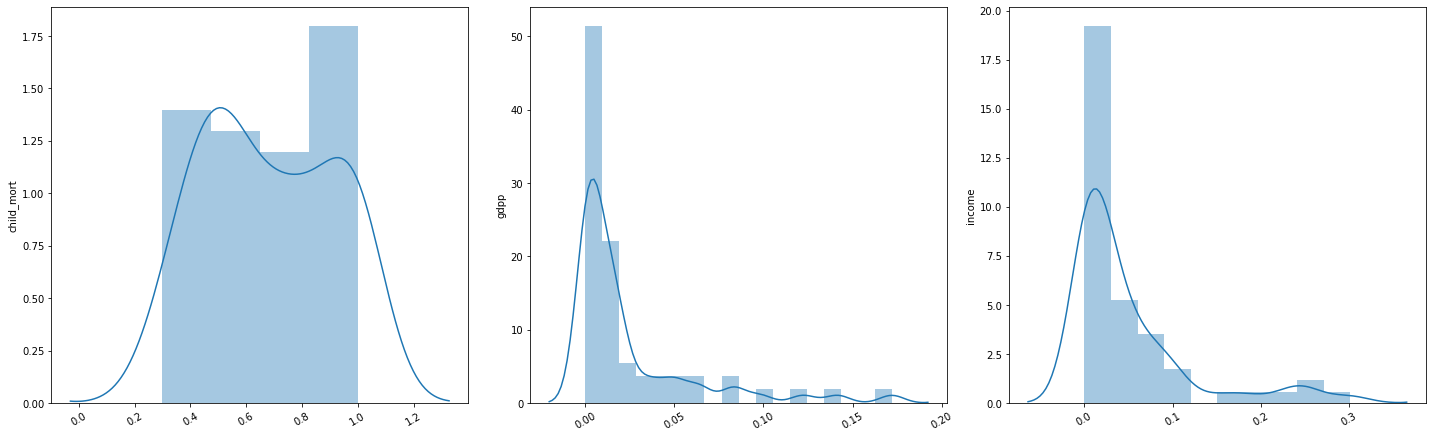

In [55]:

# Find the countries with highest: Child Mortality Rate,Fertility Rate, Inflation
# Find the countries with lowest: Life Expectancy, Health, GDP,Income,Imports,Exports
cols=['child_mort','gdpp','income']

# Bin the data and plot the dist plot of the numerical terms
plt.figure(figsize=(20, 60))
i=1
sortAsc=False
for c in cols:
    ax2 = plt.subplot(10,3,i)
    sns.distplot(final_poor_country_df[c],ax=ax2)
    ax2.set(xlabel=None, ylabel=c)
    plt.xticks(rotation=30)
    i = i + 1

plt.tight_layout()
plt.show()

In [56]:
# # pairplot of numerical variables
# cols=['child_mort','gdpp','income']
# fig = sns.PairGrid(final_poor_country_df[cols])
# fig.map_upper(sns.scatterplot,color='green')
# fig.map_lower(sns.scatterplot, color='red')
# fig.map_diag(plt.hist)
# plt.show()


<Figure size 1440x1080 with 0 Axes>

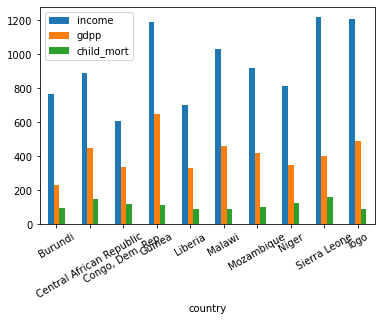

In [57]:
#Final top 10 countries in dire need of aid - data is taken from the original dataset provided

cols=['income','gdpp','child_mort']
top10_df = final_poor_country_df.sort_values(cols, ascending = [True,True,False]).head(10)
countries= top10_df.country.to_list()
top10_df = data_backup1[data_backup1.country.isin(countries)]

plt.figure(figsize=(20, 15))
top10_df.plot(x='country', y=cols,kind = 'bar')
plt.xticks(rotation=30)
plt.show()

In [58]:
top10_df

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
26,Burundi,93.6,8.92,11.60,39.2,764,12.30,57.7,6.26,231
31,Central African Republic,149.0,11.80,3.98,26.5,888,2.01,47.5,5.21,446
37,"Congo, Dem. Rep.",116.0,41.10,7.91,49.6,609,20.80,57.5,6.54,334
63,Guinea,109.0,30.30,4.93,43.2,1190,16.10,58.0,5.34,648
88,Liberia,89.3,19.10,11.80,92.6,700,5.47,60.8,5.02,327
94,Malawi,90.5,22.80,6.59,34.9,1030,12.10,53.1,5.31,459
106,Mozambique,101.0,31.50,5.21,46.2,918,7.64,54.5,5.56,419
112,Niger,123.0,22.20,5.16,49.1,814,2.55,58.8,7.49,348
132,Sierra Leone,160.0,16.80,13.10,34.5,1220,17.20,55.0,5.20,399
150,Togo,90.3,40.20,7.65,57.3,1210,1.18,58.7,4.87,488


In [59]:
# data is taken from the scaled dataset 
top10_df = final_poor_country_df.sort_values(cols, ascending = [True,True,False]).head(10)
display(top10_df)


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster_Id
31,Central African Republic,1.000000,0.000000,0.135437,0.132836,0.000000,0.088299,0.000000,0.854395,0.000000,1
37,"Congo, Dem. Rep.",1.000000,0.423375,0.583096,0.499445,0.000000,0.996616,0.067135,1.000000,0.000000,1
112,Niger,1.000000,0.147261,0.269849,0.491509,0.000000,0.114403,0.117877,1.000000,0.000000,1
106,Mozambique,0.866714,0.283126,0.275544,0.445485,0.000000,0.360456,0.000000,0.932677,0.000000,1
26,Burundi,0.800960,0.000000,1.000000,0.334391,0.000000,0.585722,0.074941,1.000000,0.000000,1
94,Malawi,0.773414,0.156026,0.432737,0.266148,0.000000,0.576054,0.000000,0.876761,0.000000,1
88,Liberia,0.762751,0.101972,1.000000,1.000000,0.000000,0.255557,0.195941,0.811899,0.000000,1
150,Togo,0.771637,0.410226,0.553480,0.621647,0.000000,0.048176,0.113973,0.778349,0.000459,1
63,Guinea,0.937800,0.265595,0.243650,0.397873,0.000000,0.769416,0.086651,0.883471,0.003782,1
132,Sierra Leone,1.000000,0.068371,1.000000,0.259800,0.000149,0.822590,0.000000,0.852158,0.000000,1


In [65]:
# plot_df['country'] = np.where(plot_df.country == 'Central African Republic','Cent. African Rep.',plot_df.country)
# plot_df
display(top10_df.country.to_list())


['Central African Republic',
 'Congo, Dem. Rep.',
 'Niger',
 'Mozambique',
 'Burundi',
 'Malawi',
 'Liberia',
 'Togo',
 'Guinea',
 'Sierra Leone']

<Figure size 2160x1440 with 0 Axes>

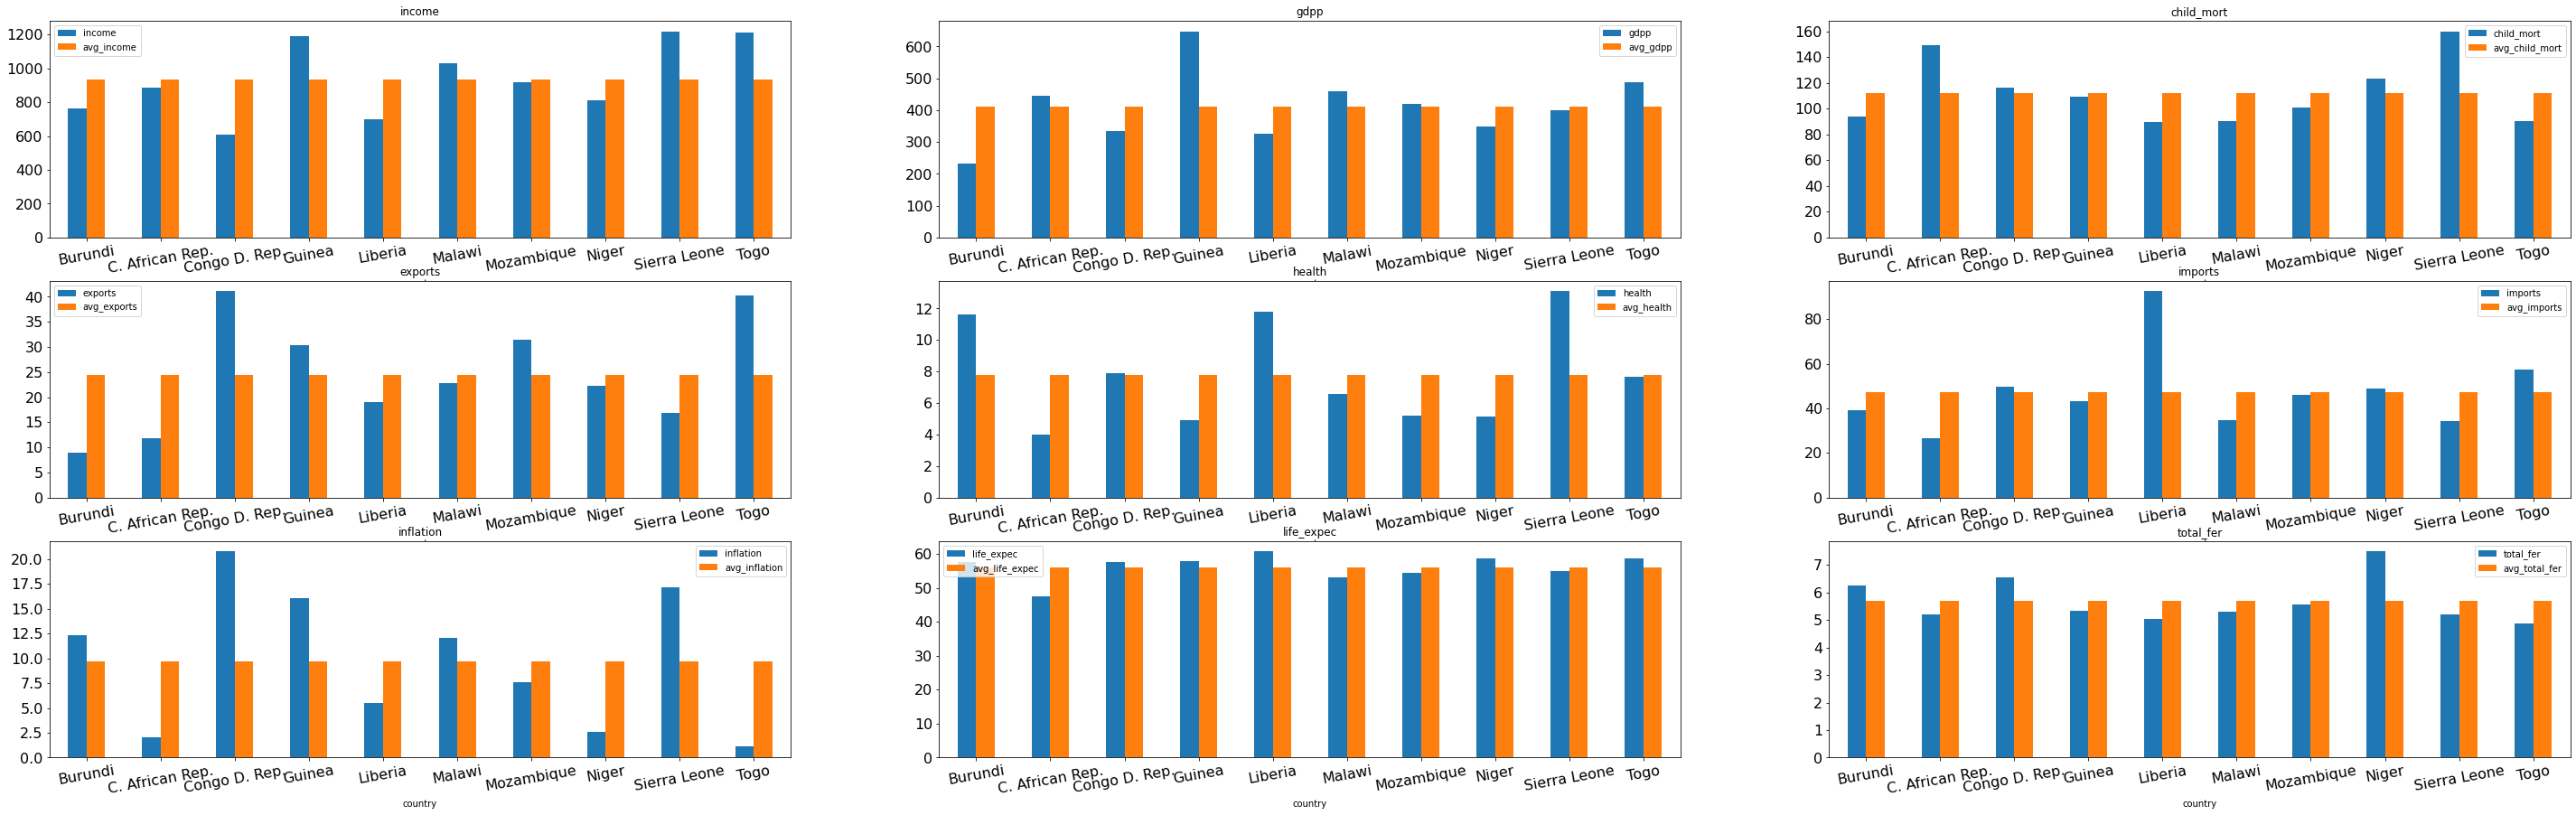

In [62]:
# Get list of top 10 recommended countries by income, GDPP and child mortality
final_df=df_list[0][1].copy()
avg_income = final_df.income.mean()
avg_gdpp = final_df.gdpp.mean()
avg_child_mort=final_df.child_mort.mean()
final_poor_country_df = final_df[np.logical_and(np.logical_and(final_df.income < avg_income,final_df.gdpp < avg_gdpp), final_df.child_mort > avg_child_mort)]
# final_poor_country_df.shape
cols=['income','gdpp','child_mort']
top10_df = final_poor_country_df.sort_values(cols, ascending = [True,True,False]).head(10)
# display(top10_df)

recommended_countries= top10_df.country.to_list()
# display(recommended_countries)

# Get the mean average values for the Underdeveloped cluster
final_df=df_list[0][1].copy()
final_df=final_df[['country','Cluster_Id']]
plot_df = data_backup1.copy()
plot_df=pd.merge(plot_df,final_df,on='country' )
plot_df['Name'] ='1'
plot_df['Name'] = np.where(plot_df.Cluster_Id == 0,'Developing',plot_df.Name)
plot_df['Name'] = np.where(plot_df.Cluster_Id == 1,'Underdeveloped',plot_df.Name)
plot_df['Name'] = np.where(plot_df.Cluster_Id == 2,'Developed',plot_df.Name)
plot_df = plot_df[plot_df.country.isin(recommended_countries)]

# display(plot_df)
mean_df = plot_df.groupby(['Cluster_Id']).mean()
mean_df.columns=['avg_child_mort','avg_exports','avg_health','avg_imports',
                 'avg_income','avg_inflation','avg_life_expec','avg_total_fer','avg_gdpp']
mean_df =mean_df.reset_index()
# display(mean_df)
# 

#Merge mean values, rename big country names
plot_df = pd.merge(plot_df,mean_df,on='Cluster_Id')
plot_df['country'] = np.where(plot_df.country == 'Central African Republic','C. African Rep.',plot_df.country)
plot_df['country'] = np.where(plot_df.country == 'Congo, Dem. Rep.','Congo D. Rep.',plot_df.country)

# display(plot_df)

cols=['income','gdpp','child_mort','exports','health','imports','inflation','life_expec','total_fer']
plt.figure(figsize=(30, 20))

plot_df_list=[]
for c in cols:
    l=['country',c,'avg_'+c]
    plot_df_list.append(plot_df[l])
#     plot_df.plot(x='country', y=l,kind = 'bar',figsize=(20, 8))
#     plt.xticks(rotation=0)
    
fig, axes = plt.subplots(3, 3)
count=0
for r in range(3):
    for c in range(3):
        df = plot_df_list[count]
#         display(df.head())
        l=[df.columns[1],df.columns[2]]
        df.plot(x='country',y=l,ax=axes[r,c],kind='bar',figsize=(50, 15),title=df.columns[1],rot=10,fontsize=16)
        
        count=count+1

##### Conclusion:
We have identified the list of below 10 countries which are in dire need of aid from the Underdeveloped cluster. We compared their values with the mean values of the other countries in the same segment.  
 - 'Central African Republic',
 - 'Congo, Dem. Rep.',
 - 'Niger',
 - 'Mozambique',
 - 'Burundi',
 - 'Malawi',
 - 'Liberia',
 - 'Togo',
 - 'Guinea',
 - 'Sierra Leone'